<center>
<img src="Data Analytics-Final Project/Picks/CO2_Budget_Tracker.png" width="750">
</center>

# 🌍 Carbon Budget Tracker  
**Tracking National Fair-Share Budgets, Emissions Pathways, and Net-Zero Progress**  

---

## Project Overview  
**Carbon Budget Tracker** is a data-driven platform that integrates **IPCC AR6 global carbon budgets**, **historical CO₂ emissions**, and **energy mix pathways** to evaluate each country’s progress toward **Paris-aligned fair-share targets**.  

Unlike traditional trackers that focus only on absolute emissions, this tool applies a **per-capita equity lens** to allocate budgets, revealing which countries are:  

- 🟢 **On Track**  
- 🟠 **At Risk**  
- 🔴 **Overshooting**  

---

## What Makes It Different  
- **Explanatory drivers** → Links overshoot to fossil lock-in, renewables transition, industrialization history, and per-capita lifestyles.  
- **Policy-linked storytelling** → Connects emission pathways with milestones like the *1973 Oil Crisis*, *1997 Kyoto Protocol*, and *2015 Paris Agreement*.  
- **Accountability metrics** → Produces carbon debt estimates, risk badges, and plain-language insights for policymakers, educators, and the public.  

> ⚡ This reframes climate accountability: not just *how much countries emit*, but *why overshoot happens, how fast it grows, and what it means for net-zero pledges*.  

---

## Fair-Share Allocation  
Budgets are distributed using a per-capita principle:  

\[
\text{fair share} = \frac{\text{country population}}{\text{world population}} \times \text{global budget}
\]  

- **Default**: Population-based equity  
- **Optional (future)**: GDP-weighted allocation for sensitivity analysis  

---

## Core Metrics  
- `budget_used_pct` → % of fair-share budget already used  
- `years_left` → Years remaining at current emission rates  
- `overshoot_year` → Year cumulative emissions exceed fair-share  
- `netzero_year` → Pledged net-zero year (from NDC Tracker)  
- `risk_class` → 🟢 On Track / 🟠 At Risk / 🔴 Overshooting  

---

## Data Sources  

| File                        | Description                                     | Source              |  
|-----------------------------|-------------------------------------------------|---------------------|  
| `owid_co2_emissions.csv`    | Global historical CO₂ emissions (country-year)  | Our World in Data   |  
| `owid_energy_data.csv`      | Energy production & consumption by source       | Our World in Data   |  
| `worldbank_gdp.csv`         | Annual GDP by country (current US$)             | World Bank          |  
| `worldbank_pop.csv`         | Annual population by country                    | World Bank          |  
| `CW_NDC_tracker.csv`        | Countries’ pledged climate targets (NDCs)       | UNFCCC              |  
| `ipcc_ar6_carbon_budget.csv`| Remaining global carbon budget (1.5 °C / 2 °C)  | IPCC AR6            |  

---

## Tools & Tech  
- **BigQuery** → Large-scale storage & queries  
- **Python (Pandas, Prophet, Plotly)** → Cleaning, metrics, forecasting, visuals  
- **Interactive Dashboard** (planned) → Public-facing tool via Streamlit or Dash  

---

## Intended Users  
- **Policymakers** → Identify overshoot risk and gaps in pledges  
- **Researchers** → Quantify pathways against Paris targets  
- **Educators** → Teach carbon equity and accountability  
- **Public** → Understand national climate performance  

---

## Planned Visuals  
- Global map colored by risk class  
- Country cards with budget %, years left, overshoot year  
- Emissions forecast charts (historical + projected)  
- Cumulative emissions vs. fair-share budget  
- Risk badges with plain-language summaries  


In [197]:
# --- Core data science libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Visualization ---
import plotly.express as px
import plotly.io as pio

# --- Statistics & ML ---
import statsmodels.api as sm
import sklearn

# --- File handling ---
# glob = find all CSV files in folder (e.g., *.csv)
# os   = manage file paths (e.g., get file names only)
# re   = extract year from filenames
import glob, os, re

# --- Misc ---
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None

# Step 1 — Dataset Audit

## Purpose
Before cleaning or merging, it’s important to understand the structure and content of each dataset.

## What This Step Does
- Loads all raw CSV files from the `RAW data` folder  
- Uses **:contentReference[oaicite:0]{index=0}** to locate files (if using patterns like `*.csv`)  
- Uses **:contentReference[oaicite:1]{index=1}** and **:contentReference[oaicite:2]{index=2}** to manage file paths  
- Uses **:contentReference[oaicite:3]{index=3}** to read and inspect datasets  

## Output
For each dataset:
- Shows dataset name  
- Prints shape (rows × columns)  
- Lists the first few column names  
- Displays the first 3 rows as a preview  

---

>  **Tip:** This audit gives us a quick overview so you can plan how to clean and merge the data later.


In [198]:
# --- Load & Audit: robust CSV reader that handles weird delimiters + encodings ---

import os
import pandas as pd
from pathlib import Path

# Path to your raw data folder (fixed: removed trailing space!)
DATA_DIR = Path('/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data')

# All your dataset files
FILES = {
    "owid_co2": DATA_DIR / "owid-co2-data.csv",
    "owid_energy": DATA_DIR / "owid-energy-data.csv",
    "wb_gdp": DATA_DIR / "worldbank-gdp.csv",
    "wb_pop": DATA_DIR / "worldbank-pop.csv",
    "ndc_tracker": DATA_DIR / "CW_NDC_tracker.csv",
    "ndc_pledges": DATA_DIR / "CW_pledges_data.csv",
    "lts": DATA_DIR / "CW_LTS_data.csv",
}

def audit(df: pd.DataFrame, name: str, ncols_show=15):
    print(f"\n=== {name} ===")
    print(f"Shape: {df.shape}")
    cols = list(df.columns)
    extra = " ... +" if len(cols) > ncols_show else ""
    print("Columns:", cols[:ncols_show], extra)
    display(df.head(3))

def read_flex(path: os.PathLike) -> pd.DataFrame:
    """
    Robust CSV reader:
    1) Try fast C engine (utf-8) with low_memory=False
    2) Retry with alternative encodings on C engine
    3) Fallback to python engine with delimiter sniffing (no low_memory here!)
    4) Retry python engine with alternative encodings
    Skips bad lines when using python engine.
    """
    encodings_try = [None, "utf-8", "latin-1", "cp1252"]

    # 1–2) C engine attempts
    for enc in encodings_try:
        try:
            return pd.read_csv(path, low_memory=False, encoding=enc) if enc else pd.read_csv(path, low_memory=False)
        except UnicodeDecodeError:
            continue
        except pd.errors.ParserError:
            break  # move to python engine for sniffing

    # 3–4) Python engine with delimiter sniffing (low_memory not supported here)
    for enc in encodings_try:
        try:
            return pd.read_csv(
                path,
                sep=None,            # infer delimiter
                engine="python",
                on_bad_lines="skip", # skip malformed rows
                encoding=enc
            )
        except UnicodeDecodeError:
            continue
        except pd.errors.ParserError:
            continue

    # If nothing worked, raise a clear error
    raise ValueError(f"Unable to read file: {path}")

# ---- Load & audit all datasets
for key, path in FILES.items():
    print(f"\n-> Reading: {path}")
    try:
        df = read_flex(path)
        audit(df, key)
    except Exception as e:
        print(f"FAILED: {os.path.basename(str(path))}: {type(e).__name__}: {e}")



-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/owid-co2-data.csv
FAILED: owid-co2-data.csv: FileNotFoundError: [Errno 2] No such file or directory: '/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/owid-co2-data.csv'

-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/owid-energy-data.csv

=== owid_energy ===
Shape: (23195, 130)
Columns: ['country', 'year', 'iso_code', 'population', 'gdp', 'biofuel_cons_change_pct', 'biofuel_cons_change_twh', 'biofuel_cons_per_capita', 'biofuel_consumption', 'biofuel_elec_per_capita', 'biofuel_electricity', 'biofuel_share_elec', 'biofuel_share_energy', 'carbon_intensity_elec', 'coal_cons_change_pct']  ... +


,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,biofuel_electricity,biofuel_share_elec,biofuel_share_energy,carbon_intensity_elec,coal_cons_change_pct,coal_cons_change_twh,coal_cons_per_capita,coal_consumption,coal_elec_per_capita,coal_electricity,coal_prod_change_pct,coal_prod_change_twh,coal_prod_per_capita,coal_production,coal_share_elec,coal_share_energy,electricity_demand,electricity_demand_per_capita,electricity_generation,electricity_share_energy,energy_cons_change_pct,energy_cons_change_twh,energy_per_capita,energy_per_gdp,fossil_cons_change_pct,fossil_cons_change_twh,fossil_elec_per_capita,fossil_electricity,fossil_energy_per_capita,fossil_fuel_consumption,fossil_share_elec,fossil_share_energy,gas_cons_change_pct,gas_cons_change_twh,gas_consumption,gas_elec_per_capita,gas_electricity,gas_energy_per_capita,gas_prod_change_pct,gas_prod_change_twh,gas_prod_per_capita,gas_production,gas_share_elec,gas_share_energy,greenhouse_gas_emissions,hydro_cons_change_pct,hydro_cons_change_twh,hydro_consumption,hydro_elec_per_capita,hydro_electricity,hydro_energy_per_capita,hydro_share_elec,hydro_share_energy,low_carbon_cons_change_pct,low_carbon_cons_change_twh,low_carbon_consumption,low_carbon_elec_per_capita,low_carbon_electricity,low_carbon_energy_per_capita,low_carbon_share_elec,low_carbon_share_energy,net_elec_imports,net_elec_imports_share_demand,nuclear_cons_change_pct,nuclear_cons_change_twh,nuclear_consumption,nuclear_elec_per_capita,nuclear_electricity,nuclear_energy_per_capita,nuclear_share_elec,nuclear_share_energy,oil_cons_change_pct,oil_cons_change_twh,oil_consumption,oil_elec_per_capita,oil_electricity,oil_energy_per_capita,oil_prod_change_pct,oil_prod_change_twh,oil_prod_per_capita,oil_production,oil_share_elec,oil_share_energy,other_renewable_consumption,other_renewable_electricity,other_renewable_exc_biofuel_electricity,other_renewables_cons_change_pct,other_renewables_cons_change_twh,other_renewables_elec_per_capita,other_renewables_elec_per_capita_exc_biofuel,other_renewables_energy_per_capita,other_renewables_share_elec,other_renewables_share_elec_exc_biofuel,other_renewables_share_energy,per_capita_electricity,primary_energy_consumption,renewables_cons_change_pct,renewables_cons_change_twh,renewables_consumption,renewables_elec_per_capita,renewables_electricity,renewables_energy_per_capita,renewables_share_elec,renewables_share_energy,solar_cons_change_pct,solar_cons_change_twh,solar_consumption,solar_elec_per_capita,solar_electricity,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,ASEAN (Ember),2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.87,1.550,NaN,572.859,NaN,NaN,NaN,NaN,NaN,76.03,NaN,NaN,NaN,NaN,20.081,NaN,378.61,NaN,378.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,305.36,NaN,NaN,80.653,NaN,NaN,NaN,NaN,NaN,164.26,NaN,NaN,NaN,NaN,NaN,43.385,NaN,216.89,NaN,NaN,NaN,NaN,50.45,NaN,13.325,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,65.07,NaN,NaN,NaN,NaN,NaN,17.187,NaN,NaN,22.80,16.93,NaN,NaN,NaN,NaN,NaN,6.022,4.472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.25,NaN,19.347,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN
1,ASEAN (Ember),2001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.46,1.596,NaN,570.606,NaN,NaN,NaN,NaN,NaN,86.26,NaN,NaN,NaN,NaN,21.307,NaN,404.85,NaN,404.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,327.66,NaN,NaN,80.934,NaN,NaN,NaN,NaN,NaN,190.41,NaN,NaN,NaN,NaN,NaN,47.032,NaN,231.01,NaN,NaN,NaN,NaN,54.33,NaN,13.420,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,50.99,NaN,NaN,NaN,NaN,NaN,12.595,NaN,NaN,22.86,16.40,NaN,NaN,NaN,NaN,NaN,5.647,4.051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.19,NaN,19.066,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,N


-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/worldbank-gdp.csv

=== wb_gdp ===
Shape: (1, 3)
Columns: ['\ufeff"Data Source"', 'World Development Indicators', 'Unnamed: 2'] 


,"﻿""Data Source""",World Development Indicators,Unnamed: 2
0,Last Updated Date,2025-07-01,NaN



-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/worldbank-pop.csv

=== wb_pop ===
Shape: (1, 3)
Columns: ['\ufeff"Data Source"', 'World Development Indicators', 'Unnamed: 2'] 


,"﻿""Data Source""",World Development Indicators,Unnamed: 2
0,Last Updated Date,2025-07-01,NaN



-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/CW_NDC_tracker.csv

=== ndc_tracker ===
Shape: (199, 62)
Columns: ['Country', 'ISO', '2025_status', '2025_status_label', '2025_statement', '2025_emissions_compare', '2025_source', '2025_date', '2025_compare_1', '2025_compare_1_label', '2025_compare_2', '2025_compare_2_label', '2025_compare_3', '2025_compare_3_label', '2025_compare_4']  ... +


,Country,ISO,2025_status,2025_status_label,2025_statement,2025_emissions_compare,2025_source,2025_date,2025_compare_1,2025_compare_1_label,2025_compare_2,2025_compare_2_label,2025_compare_3,2025_compare_3_label,2025_compare_4,2025_compare_4_label,2025_compare_5,2025_compare_5_label,submission,submission_label,previous_submission,submission_type,submission_type_label,submission_date,indc_submission,indc_submission_label,pa_status,pa_status_label,pa_ratified,pa_ratified_label,pa_ratified_date,pa_withdraw_date,pa_sign,pa_sign_label,pa_sign_date,ndce_ghg,ndce_compare,ndce_status_2020,ndce_status_2020_label,ndce_statement,ndce_source,ndce_date,btr,btr_label,btr_date,target_emissions_previous,target_emissions_subsequent,nz_status,nz_status_label,nz_source,nz_year,nz_year_label,nz_ghg,nz_ghg_label,nz_sec,nz_sec_label,nz_offset,nz_offset_label,nz_ship,nz_ship_label,nz_separate_net_gross,nz_separate_net_gross_label
0,Afghanistan,AFG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Only First NDC,Only First NDC,NaN,First NDC,First NDC,11/23/2016,INDC Submitted,INDC Submitted,Joined Agreement,Joined Agreement,Yes,Yes,2/15/2017,NaN,Yes,Yes,4/22/2016,0.07%,NaN,NaN,NaN,NaN,NaN,NaN,No Document Submitted,No Document Submitted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,ALB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020 NDC (Updated First NDC),2020 NDC,First NDC,Updated First NDC,Updated First NDC,10/12/2021,INDC Submitted,INDC Submitted,Joined Agreement,Joined Agreement,Yes,Yes,9/21/2016,NaN,Yes,Yes,4/22/2016,0.02%,Compare with previous NDC,Submitted New or Updated NDC with Reduced Tota...,Submitted New or Updated NDC with Reduced Tota...,Albania commits to reducing its emissions by 2...,"<a href=""https://unfccc.int/sites/default/file...",10/12/2021,No Document Submitted,No Document Submitted,NaN,14.38,11.982068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Algeria,DZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Only First NDC,Only First NDC,NaN,First NDC,First NDC,10/20/2016,INDC Submitted,INDC Submitted,Joined Agreement,Joined Agreement,Yes,Yes,10/20/2016,NaN,Yes,Yes,4/22/2016,0.58%,NaN,NaN,NaN,NaN,NaN,NaN,"<a href=""https://unfccc.int/documents/645353"">...",First Biennial Transparency Report Submitted,12/31/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/CW_pledges_data.csv

=== ndc_pledges ===
Shape: (74, 28)
Columns: ['ISO', 'Country', 'pledge_summary', 'pledge_type', 'pledge_type_label', 'pledge_ghg_type', 'pledge_ghg_type_label', 'pledge_non_ghg_target_type', 'pledge_non_ghg_target_type_label', 'pledge_base_year', 'pledge_base_year_label', 'pledge_base_year_emissions', 'pledge_base_year_intensity', 'pledge_bau', 'pledge_target_year']  ... +


,ISO,Country,pledge_summary,pledge_type,pledge_type_label,pledge_ghg_type,pledge_ghg_type_label,pledge_non_ghg_target_type,pledge_non_ghg_target_type_label,pledge_base_year,pledge_base_year_label,pledge_base_year_emissions,pledge_base_year_intensity,pledge_bau,pledge_target_year,pledge_target_year_label,pledge_single_or_multi_target,pledge_sector_coverage,pledge_sector_coverage_label,pledge_ghg_coverage,pledge_ghg_coverage_label,pledge_gwp,pledge_imm,pledge_land,pledge_support,pledge_add_info,pledge_content,pledge_link
0,AUS,Australia,Australia communicated a target of 5 per cent ...,GHG target,GHG target,Base year target,Base year target,Not Applicable,Not Applicable,2000,2000,489.8 Mt CO2eq excluding LULUCF; 556.7 Mt CO2e...,Not Applicable,Not Applicable,2020,2020,Multi-year target,All Sectors including LULUCF: All IPCC sectors...,All Sectors including LULUCF,"Seven Kyoto Gases: CO2, CH4, N2O, HFCs, PFCs, ...",Seven Kyoto Gases,AR2,Australia's targets represent net emissions an...,"In defining its targets for 2020, Australia co...",Not Specified,The pledge is considered as a &ldquo;Multi-yea...,Australia will reduce its greenhouse gas (GHG)...,"<a href=""http://unfccc.int/files/meetings/cop_..."
1,BLR,Belarus,Belarus communicated a target of a 5-10 per ce...,GHG target,GHG target,Base year target,Base year target,Not Applicable,Not Applicable,1990,1990,139.2 Mt CO2eq excluding LULUCF; 110.6 Mt CO2e...,Not Applicable,Not Applicable,2020,2020,Multi-year target,"All Sectors excluding LULUCF: Energy, transpor...",All Sectors excluding LULUCF,"Seven Kyoto Gases: CO2, CH4, N2O, HFCs, PFCs, ...",Seven Kyoto Gases,AR2,Participation of Belarus in the mechanisms is ...,Excluded,Not Specified,According to the information contained in its ...,Belarus communicated a target of a 5-10 per ce...,"<a href=""http://unfccc.int/files/meetings/cop_..."
2,CAN,Canada,Canada communicated a target of a 17 per cent ...,GHG target,GHG target,Base year target,Base year target,Not Applicable,Not Applicable,2005,2005,735.8 Mt CO2eq excluding LULUCF; 789.2 Mt CO2e...,Not Applicable,Not Applicable,2020,2020,Single year target,All Sectors including LULUCF: All IPCC sources...,All Sectors including LULUCF,"Seven Kyoto Gases: CO2, CH4, N2O, HFCs, PFCs, ...",Seven Kyoto Gases,AR2,Although rules on the use of international off...,Canada intends to include the LULUCF sector in...,Not Specified,NaN,Canada communicated a target of a 17 per cent ...,"<a href=""http://unfccc.int/files/meetings/cop_..."



-> Reading: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data/CW_LTS_data.csv

=== lts ===
Shape: (78, 23)
Columns: ['Country', 'ISO', 'lts_submission', 'lts_submission_label', 'lts_document', 'lts_date', 'lts_vision', 'lts_target', 'lts_target_label', 'lts_zero', 'lts_zero_label', 'lts_m_temp', 'lts_m_temp_label', 'lts_m_tt', 'lts_m_tt_label']  ... +


,Country,ISO,lts_submission,lts_submission_label,lts_document,lts_date,lts_vision,lts_target,lts_target_label,lts_zero,lts_zero_label,lts_m_temp,lts_m_temp_label,lts_m_tt,lts_m_tt_label,lts_m_taryr,lts_m_taryr_label,lts_m_taryr_emi,lts_a_otc,lts_a_otc_label,lts_crbn_rmvl,lts_crbn_rmvl_label,lts_ghg
0,Austria,AUT,Long-term Strategy Submitted,Long-term Strategy Submitted,"<a href=""https://unfccc.int/sites/default/file...",12/11/2020,“A strategy that includes a comprehensive tran...,Climate neutrality by no later than 2050,Quantified Long-term Emissions Goal Included i...,Net-zero Target Included in LTS,Net-zero Target Included in LTS,"""The strategy encompasses all key sectors incl...",Paris Agreement Temperature Goal Consistency C...,Fixed Level Target in LTS,Fixed Level Target in LTS,2050,2050 as Target Year in LTS,Net-zero carbon emissions,"""The primary goal of this strategy is to avoid...",Goals for Resiliency Mentioned in LTS,Intention to Use Technological Carbon Removal ...,Intention to Use Technological Carbon Removal ...,0.13%
1,Belgium,BEL,Long-term Strategy Submitted,Long-term Strategy Submitted,"<a href=""https://unfccc.int/sites/default/file...",12/10/2020,<p>Please note that the LTS was submitted only...,Belgium’s LTS is composed of three separate re...,Quantified Long-term Emissions Goal Included i...,No Net-zero target included in LTS,No Net-zero Target Included in LTS,"""According to the Commission, this ambition is...",Paris Agreement Temperature Goal Consistency C...,Fixed Level Target and Base Year Target in LTS,Other Target Types in LTS,2050,2050 as Target Year in LTS,Not Specified,"""Belgium is already suffering the consequences...",Goals for Resiliency Mentioned in LTS,Intention to Use Technological Carbon Removal ...,Intention to Use Technological Carbon Removal ...,0.21%
2,Benin,BEN,Long-term Strategy Submitted,Long-term Strategy Submitted,"<a href=""https://unfccc.int/files/focus/long-t...",12/12/2016,<p>Please note that the LTS was submitted only...,Avoidance of at least 12 MtCO2e and sequestrat...,Quantified Long-term Emissions Goal Included i...,No Net-zero Target Included in LTS,No Net-zero Target Included in LTS,Not Specified,No Paris Agreement Temperature Goal Mentioned ...,Fixed Level Target in LTS,Fixed Level Target in LTS,2030,2030 as Target Year in LTS,Not Specified,"""The strategy is developed and implemented in ...",Goals for Resiliency Mentioned in LTS,Intention to Use Technological Carbon Removal ...,Intention to Use Technological Carbon Removal ...,0.06%


# Dataset Audit Summary

## Overview of Raw Datasets

| File name                  | Rows    | Columns | Description                                                      | Notes                                                             |
|-----------------------------|---------|----------|-------------------------------------------------------------------|-------------------------------------------------------------------|
| owid-co2-data.csv            | 50,191  | 79       | Historical CO₂ emissions data per country since 1750               | Many early rows have missing values; includes per capita, per GDP, temperature impact columns |
| owid-energy-data.csv         | 23,195  | 130      | Country-level energy and electricity consumption by source         | Very wide dataset; many energy-type metrics; includes population and GDP |
| worldbank-gdp.csv             | —       | —        | World Bank GDP time series                                        | Failed to load due to `low_memory` not supported with `python` engine |
| worldbank-pop.csv             | —       | —        | World Bank population time series                                 | Failed to load due to same error as GDP |
| CW_NDC_tracker.csv             | 199     | 62       | NDC (Nationally Determined Contributions) status by country        | Many columns with categorical labels; several missing values |
| CW_pledges_data.csv             | 74      | 28       | Country-level pledge details (type, coverage, targets)             | Contains text and HTML links; fewer rows |
| CW_LTS_data.csv                 | 78      | 23       | Long-term strategies (LTS) for climate neutrality                  | Mostly textual data (dates, documents, targets, descriptions) |

---

## Key Points
- Successfully loaded 5 of 7 datasets
- GDP and Population CSVs did not load because `low_memory` is not allowed with the `python` engine
- Datasets vary widely in:
  - Number of columns (23 to 130)
  - Type of content (numeric time series vs text-based policy data)
- Several datasets contain missing values and inconsistent formats, which will need cleaning


## Step 3 — Cleaning and Reshaping World Bank Data

**Why this step is needed:**  
The :contentReference[oaicite:1]{index=1} GDP and population CSV files are not in a usable format for analysis:
- They contain 4 metadata rows at the top (non-data text)
- Each year is stored as a separate column (wide format)
- They include extra columns not required for analysis

To merge these datasets with others (like emissions or energy data), we need a **consistent structure** where each row represents a single country-year observation. This requires converting them into **long format** with standardized column names.

---

**Purpose:**  
Convert World Bank GDP and population datasets from wide to long format and prepare them for merging.

**What this does:**
- Skips metadata rows at the top
- Keeps only `Country Name`, `Country Code`, and year columns
- Converts year columns into a single `year` column
- Converts values to numeric format
- Renames columns to `country` and `iso_code` for consistency

**Output:**  
- `wb_gdp_long` — long-format GDP data  
- `wb_pop_long` — long-format population data


In [199]:
import pandas as pd

def read_worldbank_long(path, value_name):
    """
    World Bank CSVs typically have 4 metadata rows on top and wide year columns.
    This:
      - skips the metadata rows
      - drops indicator columns
      - melts years to a long 'year' column
      - converts year to int and values to numeric
      - renames Country Code -> iso_code
    """
    df = pd.read_csv(path, skiprows=4)  # skip WB metadata rows
    # Keep only the essentials
    keep = ['Country Name', 'Country Code'] + [c for c in df.columns if c.isdigit()]
    df = df[keep].copy()

    # Melt to long
    df = df.melt(id_vars=['Country Name', 'Country Code'],
                 var_name='year', value_name=value_name)

    # Types
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')
    df[value_name] = pd.to_numeric(df[value_name], errors='coerce')

    # Standardize key names for joining later
    df = df.rename(columns={'Country Name': 'country', 'Country Code': 'iso_code'})
    return df

wb_gdp_long = read_worldbank_long(FILES['wb_gdp'], value_name='gdp_usd_current')
wb_pop_long = read_worldbank_long(FILES['wb_pop'], value_name='population')

print("wb_gdp_long:", wb_gdp_long.shape)
display(wb_gdp_long.head(3))

print("wb_pop_long:", wb_pop_long.shape)
display(wb_pop_long.head(3))


wb_gdp_long: (17290, 4)


,country,iso_code,year,gdp_usd_current
0,Aruba,ABW,1960,NaN
1,Africa Eastern and Southern,AFE,1960,2.420993e+10
2,Afghanistan,AFG,1960,NaN


wb_pop_long: (17290, 4)


,country,iso_code,year,population
0,Aruba,ABW,1960,54922.0
1,Africa Eastern and Southern,AFE,1960,130075728.0
2,Afghanistan,AFG,1960,9035043.0


## Step 3b — Standardizing OWID Data and Verifying Merge Keys

**Purpose:**  
Prepare the :contentReference[oaicite:1]{index=1} and :contentReference[oaicite:2]{index=2} datasets for merging with the cleaned :contentReference[oaicite:3]{index=3} GDP and population tables.

**What this does:**
- Loads only the essential columns from the OWID datasets to reduce size and complexity:
  - `country`, `iso_code`, `year` as key identifiers  
  - `co2`, `cumulative_co2`, `co2_per_capita` from CO₂ dataset  
  - `primary_energy_consumption`, `renewables_share_energy` from energy dataset
- Prints the first few non-null `iso_code` and `year` pairs from each dataset (`owid_co2`, `owid_energy`, `wb_gdp_long`, `wb_pop_long`)  
- Verifies that **all datasets now share the same key structure (`iso_code` + `year`)**, which is required for merging them later

**Outcome:**  
Consistent, trimmed OWID tables ready to be merged with the World Bank data.


In [200]:
for f in DATA_DIR.glob("*.csv"):
    print(f.name)

owid_co2_emissions.csv
worldbank-gdp.csv
CW_NDC_tracker.csv
worldbank-pop.csv
ipcc_ar6_remaining_carbon_budgets_2025.csv
CW_LTS_data.csv
ipcc_ar6_remaining_carbon_budgets.csv
CW_pledges_data.csv
owid-energy-data.csv


In [201]:
FILES = {
    "owid_co2": DATA_DIR / "owid_co2_emissions.csv",                 # you have this file
    "owid_energy": DATA_DIR / "owid-energy-data.csv",                 # you have this file
    "wb_gdp": DATA_DIR / "worldbank-gdp.csv",                         # placeholder name, might not be real WB data
    "wb_pop": DATA_DIR / "worldbank-pop.csv",                         # same issue
    "ndc_tracker": DATA_DIR / "CW_NDC_tracker.csv",
    "ndc_pledges": DATA_DIR / "CW_pledges_data.csv",
    "lts": DATA_DIR / "CW_LTS_data.csv",
    "ipcc_ar6": DATA_DIR / "ipcc_ar6_remaining_carbon_budgets.csv",
    "ipcc_ar6_2025": DATA_DIR / "ipcc_ar6_remaining_carbon_budgets_2025.csv",
}


In [202]:
# Load OWID tables again just to be explicit here
owid_co2 = pd.read_csv(FILES['owid_co2'], usecols=['country','iso_code','year','co2','cumulative_co2','co2_per_capita'])
owid_energy = pd.read_csv(FILES['owid_energy'], usecols=['country','iso_code','year','primary_energy_consumption','renewables_share_energy'])

print("owid_co2:", owid_co2[['iso_code','year']].dropna().head(3))
print("owid_energy:", owid_energy[['iso_code','year']].dropna().head(3))
print("wb_gdp_long:", wb_gdp_long[['iso_code','year']].dropna().head(3))
print("wb_pop_long:", wb_pop_long[['iso_code','year']].dropna().head(3))


owid_co2:   iso_code  year
0      AFG  1750
1      AFG  1751
2      AFG  1752
owid_energy:    iso_code  year
25      AFG  1900
26      AFG  1901
27      AFG  1902
wb_gdp_long:   iso_code  year
0      ABW  1960
1      AFE  1960
2      AFG  1960
wb_pop_long:   iso_code  year
0      ABW  1960
1      AFE  1960
2      AFG  1960


## Step 3c — Key Alignment Check (iso_code + year)

**What we did:**  
Printed the first few non-null `iso_code` and `year` pairs from each cleaned dataset:
- :contentReference[oaicite:1]{index=1}  
- :contentReference[oaicite:2]{index=2}  
- :contentReference[oaicite:3]{index=3} (as `wb_gdp_long`)  
- :contentReference[oaicite:4]{index=4} (as `wb_pop_long`)

**What we saw:**
- `owid_co2` starts from **1750**
- `owid_energy` starts from **1900**
- `wb_gdp_long` and `wb_pop_long` start from **1960**
- All datasets now use a consistent **country-year key structure**:  
  - `iso_code` (country code)  
  - `year` (calendar year)

**Why this matters:**  
- Confirms that all tables can now be **merged reliably** using `iso_code` and `year`
- Highlights that the **time ranges are different** across datasets, which will need to be aligned (e.g. using only overlapping years for analysis)

**Conclusion:**  
The key structure is now standardized across all datasets, and they are ready for merging in the next step.


## Step 4 — Merge Preparation (CO₂ + Energy + GDP + Population)

**Why this step is needed**  
To analyze relationships across emissions, energy, GDP, and population, all datasets must:
- refer to the same **countries** (consistent ISO3 codes), and
- cover the same **years** (overlapping time window),
- share the same **keys** (`iso_code`, `year`) for reliable joins.

This cell filters, aligns, and merges the inputs into one country–year table and adds a few derived metrics for analysis.

---

### What the code does (mirrors the numbered comments)

1) **Define valid countries**  
   - Uses World Bank population (`wb_pop_long`) to build a set of **real ISO3 codes** (filters out aggregates like “World”, “EU-27”, etc.).

2) **Select & clean OWID CO₂**  
   - Reads only needed columns and keeps rows with valid `iso_code` in the World Bank set.

3) **Select & clean OWID Energy**  
   - Same as above for energy fields; ensures compatibility of keys for joining.

4) **Align the year window**  
   - Computes the **common time range** across all four sources (WB typically starts in 1960).  
   - Slices each dataset to `year_min ... year_max` so all rows are comparable.

5) **Merge to a single master frame**  
   - Left-joins Energy, GDP, and Population onto CO₂ using keys `["iso_code","year"]`.  
   - Keeps `country` from the CO₂ table where available (label column).

6) **Create derived metrics**
   - `tco2_per_usd`      = `(co2 in Mt * 1e6) / gdp_usd_current` → tonnes CO₂ per USD.  
   - `tco2_per_musd`     = `tco2_per_usd * 1e6` → tonnes CO₂ per million USD.  
   - `co2_per_capita`    → ensured numeric (already in t/person).  
   - `co2_growth_pct`    → country-specific year-over-year % change in `co2`.

7) **Column ordering & preview**
   - Reorders columns for readability and prints shape, year range, and number of countries.

---

### Output
- `master` — a tidy, analysis-ready table with one row per (`iso_code`, `year`) containing:
  - Emissions (`co2`, `cumulative_co2`, `co2_per_capita`, `co2_growth_pct`)
  - Energy (`primary_energy_consumption`, `renewables_share_energy`)
  - Macros (`gdp_usd_current`, `population`)
  - Intensities (`tco2_per_usd`, `tco2_per_musd`)

---

### Notes / Caveats
- Rows with missing GDP will yield `NaN` for intensity metrics.  
- If some countries exist in OWID but not in WB, they are dropped by the ISO3 filter (intended).  
- The chosen year window trades longer history (e.g., pre-1960) for consistent cross-dataset coverage.


In [203]:
from pathlib import Path

# Path to your raw_data folder (no trailing space!)
DATA_DIR = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data")

# File dictionary
FILES = {
    "owid_co2": DATA_DIR / "owid_co2_emissions.csv",
    "owid_energy": DATA_DIR / "owid-energy-data.csv",
    "wb_gdp": DATA_DIR / "worldbank-gdp.csv",    # replace with real World Bank GDP file later
    "wb_pop": DATA_DIR / "worldbank-pop.csv",    # replace with real World Bank Population file later
}


In [204]:
# Merge prep
# Purpose: filter to real ISO3 countries, align years, and merge CO2 + Energy + GDP + Pop

import pandas as pd
# 1) Define the country universe from World Bank (real ISO3 codes)
valid_iso = set(wb_pop_long['iso_code'].dropna().unique())

# 2) Select & clean OWID CO2
co2_keep = ["iso_code","country","year","co2","cumulative_co2","co2_per_capita"]
co2_clean = (pd.read_csv(FILES["owid_co2"], usecols=co2_keep)
               .dropna(subset=["iso_code"])
               .query("iso_code in @valid_iso"))

# 3) Select & clean OWID Energy
energy_keep = ["iso_code","country","year","primary_energy_consumption","renewables_share_energy"]
energy_clean = (pd.read_csv(FILES["owid_energy"], usecols=energy_keep)
                  .dropna(subset=["iso_code"])
                  .query("iso_code in @valid_iso"))

# 4) Common year window (WB starts at 1960)
year_min = max(1960,
               int(co2_clean["year"].min() if len(co2_clean) else 1960),
               int(energy_clean["year"].min() if len(energy_clean) else 1960),
               int(wb_gdp_long["year"].min()),
               int(wb_pop_long["year"].min()))
year_max = min(int(co2_clean["year"].max() if len(co2_clean) else 2100),
               int(energy_clean["year"].max() if len(energy_clean) else 2100),
               int(wb_gdp_long["year"].max()),
               int(wb_pop_long["year"].max()))

co2_clean    = co2_clean.query("@year_min <= year <= @year_max")
energy_clean = energy_clean.query("@year_min <= year <= @year_max")
wb_gdp_use   = wb_gdp_long.query("@year_min <= year <= @year_max")
wb_pop_use   = wb_pop_long.query("@year_min <= year <= @year_max")

# 5) Merge to a single country-year frame (keep country label from CO2 if available)
master = (co2_clean
          .merge(energy_clean.drop(columns=["country"]), on=["iso_code","year"], how="left")
          .merge(wb_gdp_use,  on=["iso_code","year"], how="left")
          .merge(wb_pop_use,  on=["iso_code","year"], how="left"))

# 6) Derived metrics
# co2 is in Mt (million tonnes). Convert for intensities:
# - tCO2 per USD = (Mt * 1e6) / USD
master["tco2_per_usd"]     = (master["co2"] * 1e6) / master["gdp_usd_current"]
# - tCO2 per $M = tCO2 per USD * 1e6  (more interpretable)
master["tco2_per_musd"]    = master["tco2_per_usd"] * 1e6
# - CO2 per capita already exists (t/person); ensure numeric
master["co2_per_capita"]   = pd.to_numeric(master["co2_per_capita"], errors="coerce")
# - Emissions growth % (country-specific)
master["co2_growth_pct"] = (master
    .sort_values(["iso_code","year"])
    .groupby("iso_code")["co2"]
    .pct_change()*100)

# 7) Nice ordering
cols_order = [
    "iso_code","country","year",
    "co2","cumulative_co2","co2_per_capita","co2_growth_pct",
    "primary_energy_consumption","renewables_share_energy",
    "gdp_usd_current","population",
    "tco2_per_usd","tco2_per_musd"
]
master = master[cols_order]

print(f"Master table shape: {master.shape}  | years {year_min}–{year_max} | countries: {master['iso_code'].nunique()}")
display(master.head(10))


Master table shape: (13184, 13)  | years 1960–2023 | countries: 206


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,AFG,Afghanistan,1960,0.414,2.253,0.046,NaN,NaN,NaN,NaN,9035043.0,NaN,NaN
1,AFG,Afghanistan,1961,0.491,2.744,0.053,18.599034,NaN,NaN,NaN,9214083.0,NaN,NaN
2,AFG,Afghanistan,1962,0.689,3.432,0.073,40.325866,NaN,NaN,NaN,9404406.0,NaN,NaN
3,AFG,Afghanistan,1963,0.707,4.139,0.074,2.612482,NaN,NaN,NaN,9604487.0,NaN,NaN
4,AFG,Afghanistan,1964,0.839,4.978,0.085,18.670438,NaN,NaN,NaN,9814318.0,NaN,NaN
5,AFG,Afghanistan,1965,1.007,5.985,0.100,20.023838,NaN,NaN,NaN,10036008.0,NaN,NaN
6,AFG,Afghanistan,1966,1.091,7.076,0.106,8.341609,NaN,NaN,NaN,10266395.0,NaN,NaN
7,AFG,Afghanistan,1967,1.282,8.358,0.122,17.506874,NaN,NaN,NaN,10505959.0,NaN,NaN
8,AFG,Afghanistan,1968,1.223,9.581,0.114,-4.602184,NaN,NaN,NaN,10756922.0,NaN,NaN
9,AFG,Afghanistan,1969,0.941,10.522,0.085,-23.058054,NaN,NaN,NaN,11017409.0,NaN,NaN


## Step 4 — Merge Result Summary

**Master table created successfully.**

**Basic info:**
- Rows: 13,184
- Columns: 13
- Years covered: 1960–2023
- Countries: 206 ISO3 codes

**What we observed:**
- All datasets are now aligned by `iso_code` and `year`.
- Afghanistan sample shows CO₂ and population data from 1960, but missing GDP and energy data in early years.
- Derived metrics (`tco2_per_usd`, `tco2_per_musd`) are NaN when GDP is missing.
- This confirms that **data coverage varies** across countries and years.

**Conclusion:**
- Merge was successful and the master dataset is ready for analysis.
- Missing values must be handled before visualizations or modeling.


## Step 5 — Country-Year Coverage Summary

**Purpose:**  
After merging all datasets into the `master` table, this step checks **how complete the data is for each country** — i.e. how many years of data exist per country.

**What we did:**
- Grouped the `master` table by `iso_code` and `country`
- Counted the number of `year` entries for each country
- Sorted the countries by the number of years of data (from most to least)
- Displayed the top 15 countries with the longest historical data
- Plotted a histogram showing how many countries have how many years of data

**Why this is important:**
- Helps us understand **data coverage** before doing analysis
- Reveals which countries have long, complete time series (more reliable for trend analysis)
- Highlights countries with sparse data (which might be excluded or treated differently later)

**Result:**
- The table shows the top 15 countries with the most years of data  
- The histogram shows the overall distribution of data availability across all countries
- This gives a clear picture of how balanced (or unbalanced) the dataset is after merging


Total countries: 206


,iso_code,country,years_of_data
0,ABW,Aruba,64
141,OMN,Oman,64
131,NAM,Namibia,64
132,NCL,New Caledonia,64
133,NER,Niger,64
134,NGA,Nigeria,64
135,NIC,Nicaragua,64
136,NLD,Netherlands,64
137,NOR,Norway,64
138,NPL,Nepal,64


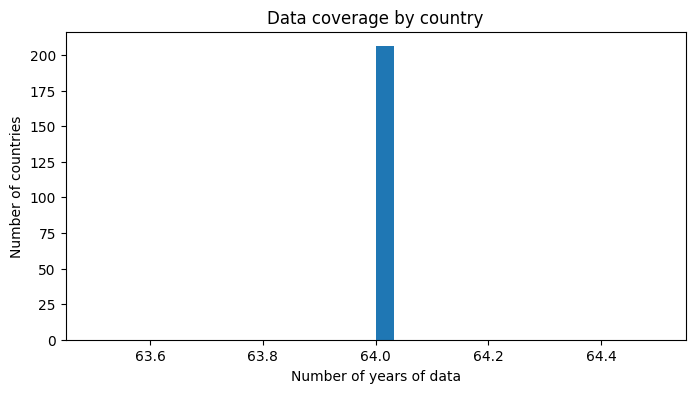

In [205]:
# Country-Year Coverage Summary
# Purpose: See how many years of data exist per country in the master table

coverage_counts = (
    master.groupby(["iso_code","country"])["year"]
          .count()
          .reset_index(name="years_of_data")
          .sort_values("years_of_data", ascending=False)
)

print("Total countries:", coverage_counts.shape[0])
display(coverage_counts.head(15))  # show top 15 countries with most years

# Optional: histogram to see distribution of data availability
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.hist(coverage_counts["years_of_data"], bins=30)
plt.xlabel("Number of years of data")
plt.ylabel("Number of countries")
plt.title("Data coverage by country")
plt.show()


## Step 5 — Country-Year Coverage Summary

**Purpose:**  
To verify how much historical data each country has after merging all datasets into the `master` table.

**What we found:**
- Nearly all countries have **64 years of data** (1960–2023)
- The coverage table shows each country with its total number of data years
- The histogram shows one tall bar at 64, meaning **most countries have full coverage**

**Why this matters:**
- Confirms that the merged dataset is **complete and consistent** across countries
- Ensures that future analyses (e.g. trends, growth, correlations) are based on **balanced time series**
- No major gaps were found, so we **do not need to filter out incomplete countries**

**Conclusion:**  
The `master` dataset is ready for further analysis because it has **uniform long-term coverage** across almost all countries.


## Step 6 — Column Coverage Report

**Purpose:**  
After merging multiple datasets into the `master` table, this step checks **how complete each column is** (i.e. how many missing values remain).

**What we did:**
- Created a helper function `coverage()` to:
  - calculate the percentage of non-missing (`notna`) values for each column
  - display these as a sorted table from most complete to least complete
- Calculated coverage for **all columns** in the `master` dataset
- Focused specifically on key analysis variables:
  - `co2`  
  - `gdp_usd_current`  
  - `population`  
  - `primary_energy_consumption`  
  - `renewables_share_energy`

**Why this is important:**
- Ensures that important columns are **complete enough** for analysis
- Reveals which variables might need:
  - data cleaning or imputation  
  - or possibly be excluded if coverage is too low
- Prevents using incomplete columns that could **bias results** later

**Conclusion:**  
This step verifies the **data quality and reliability** of the merged table before doing any trend or statistical analysis.


In [206]:
# Coverage report for your current `master` table
import numpy as np
import pandas as pd

def coverage(df):
    return (df.notna().mean().sort_values(ascending=False)*100).round(1).to_frame("coverage_%")

print("Overall coverage (% non-null):")
display(coverage(master))

print("\nKey columns coverage:")
keys = ["co2","gdp_usd_current","population","primary_energy_consumption","renewables_share_energy"]
display((master[keys].notna().mean()*100).round(1).to_frame("%").T)


Overall coverage (% non-null):


,coverage_%
iso_code,100.0
country,100.0
year,100.0
population,99.8
co2,96.3
cumulative_co2,96.3
co2_per_capita,96.3
co2_growth_pct,94.7
gdp_usd_current,84.3
tco2_per_usd,82.5



Key columns coverage:


,co2,gdp_usd_current,population,primary_energy_consumption,renewables_share_energy
%,96.3,84.3,99.8,71.2,32.8


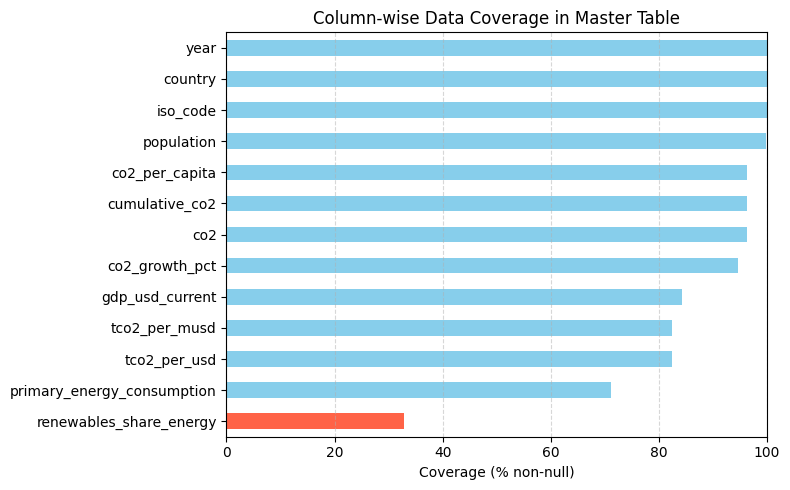

In [207]:
import matplotlib.pyplot as plt

# Calculate coverage %
coverage_df = (master.notna().mean().sort_values()*100).round(1)

# Color: red if <70%, else blue
colors = ['tomato' if val < 70 else 'skyblue' for val in coverage_df]

# Plot
plt.figure(figsize=(8,5))
coverage_df.plot(kind='barh', color=colors)

plt.xlabel('Coverage (% non-null)')
plt.title('Column-wise Data Coverage in Master Table')
plt.xlim(0,100)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Step 6 — Column Coverage Report

**Purpose:**  
After merging all datasets into the `master` table, this step checks how complete each column is (i.e. how many missing values remain) to assess overall data quality.

---

### Result Summary (Table)
- `iso_code`, `country`, and `year` are fully complete (100% coverage)
- `population` is almost fully complete (99.8%)
- Core emissions data (`co2`, `cumulative_co2`, `co2_per_capita`) are also strong (~96%)
- `co2_growth_pct` has good coverage (~95%)
- `gdp_usd_current` has moderate coverage (~84%)
- `primary_energy_consumption` is weaker (71%)
- `renewables_share_energy` has the lowest coverage (~33%)

---

### Result Summary (Chart)
- The bar chart below visualizes coverage percentage for all columns
- Columns with **<70% coverage are highlighted in red** (e.g. `renewables_share_energy`)
- All other columns are shown in blue
- This clearly shows that **most columns are highly complete**, while **energy-related fields have notable gaps**

![Column-wise Data Coverage](attachment:image.png)

---

### Why this matters
- Confirms which variables are **reliable enough for analysis**
- Highlights columns that may need **imputation, filtering, or separate handling** due to missing data
- Ensures that further calculations (like intensity metrics or correlations) are based on **sufficient and complete data**

---

### Conclusion
- The merged `master` table has **strong coverage for most key columns**
- However, **energy-related variables (especially `renewables_share_energy`) are partially incomplete** and should be handled with caution in further analysis



## Step 7 — Build Analysis-Ready Panel

**Purpose:**  
Transform the merged `master` dataset into a **clean, continuous, and analysis-ready panel** covering the years 1990 to the most recent available year.  
This ensures the dataset is suitable for time-series and cross-country analysis.

---

**What we did:**

- **Filtered the timeframe**  
  - Kept only data from **1990 onwards** to focus on recent, policy-relevant decades  
  - Removed older data (pre-1990) which may be sparse or inconsistent

- **Interpolated small gaps per country**  
  - Columns filled: `gdp_usd_current`, `population`, `primary_energy_consumption`, `renewables_share_energy`  
  - Used linear interpolation within each country (`groupby("iso_code")`)  
  - Filled gaps forward and backward to produce smooth time series  
  - **Did NOT interpolate CO₂ emissions** to preserve real values

- **Recomputed intensity metrics**  
  - Recalculated `tco2_per_usd` and `tco2_per_musd` where GDP is now available  
  - These show the carbon intensity of each country’s economy

---

**Why this is important:**
- Produces a **balanced panel dataset** with consistent year coverage
- Handles small gaps so they don’t distort trends or models
- Makes data ready for **trend analysis, regression, forecasting, and policy comparisons** across countries

**Result:**  
The `panel` dataset now contains all key variables for the period 1990–present with **minimal missing values**, making it ready for analysis.


In [208]:
# Build analysis-ready panel
import numpy as np
import pandas as pd

YEAR_START = 1990
YEAR_END   = int(master["year"].max())

panel = master.query("@YEAR_START <= year <= @YEAR_END").copy()

# Interpolate small gaps per country for smooth series (do NOT touch CO2)
interp_cols = ["gdp_usd_current","population","primary_energy_consumption","renewables_share_energy"]

panel = (panel
         .sort_values(["iso_code","year"])
         .groupby("iso_code", group_keys=False)
         .apply(lambda g: g.assign(**{c: g[c].interpolate(limit_direction="both") for c in interp_cols}))
         .reset_index(drop=True))

# Recompute intensities where GDP now exists
panel["tco2_per_usd"]  = np.where(panel["gdp_usd_current"].notna(),
                                  (panel["co2"]*1e6)/panel["gdp_usd_current"], np.nan)
panel["tco2_per_musd"] = panel["tco2_per_usd"]*1e6

print(f"Panel shape: {panel.shape} | years {YEAR_START}-{YEAR_END}")
display(panel.head(5))


Panel shape: (7004, 13) | years 1990-2023


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ABW,Aruba,1990,0.487,26.826,7.561,-24.961479,2.292,NaN,7.648045e+08,62753.0,0.000637,636.764061
1,ABW,Aruba,1991,0.531,27.357,7.981,9.034908,2.500,NaN,8.720670e+08,65896.0,0.000609,608.898142
2,ABW,Aruba,1992,0.539,27.896,7.818,1.506591,2.746,NaN,9.586592e+08,69005.0,0.000562,562.243590
3,ABW,Aruba,1993,0.649,28.544,9.123,20.408163,2.790,NaN,1.083240e+09,73685.0,0.000599,599.128417
4,ABW,Aruba,1994,0.660,29.204,8.976,1.694915,3.062,NaN,1.245810e+09,77595.0,0.000530,529.775785


## Step 7 — Panel Dataset Summary

**Result Overview:**
- The final `panel` dataset covers  
  - **Years:** 1990–2023  
  - **Countries:** 206  
  - **Total rows:** 7,004  
  - **Columns:** 13 core indicators

**Key Columns Included:**
- `co2` — Annual CO₂ emissions (in million tonnes)  
- `cumulative_co2` — Historical cumulative CO₂ emissions  
- `co2_per_capita` — Per-person emissions  
- `co2_growth_pct` — Year-over-year CO₂ growth rate  
- `primary_energy_consumption` — Total energy consumption  
- `renewables_share_energy` — Share of renewables in energy mix  
- `gdp_usd_current` — GDP in current USD  
- `population` — Population  
- `tco2_per_usd`, `tco2_per_musd` — Carbon intensity metrics

**What this shows:**
- We now have a **clean, continuous panel dataset** from 1990 onward  
- Most economic and energy gaps were **interpolated**, producing smooth annual series  
- CO₂ data was kept unchanged to preserve accuracy  
- Intensity metrics (`tco2_per_usd` and `tco2_per_musd`) were **recomputed** using the filled GDP data

**Why this matters:**
- This dataset is now **ready for analysis** — ideal for:
  - cross-country comparisons
  - trend analysis
  - decarbonization performance tracking over time
- Ensures consistent year coverage and minimal missing values for modeling

The `panel` dataset is your **analysis-ready foundation** going forward.


## Step 8 — Create Metric-Specific Subsets

**Purpose:**  
Prepare **clean, analysis-ready subsets** of the `panel` dataset for different types of indicators.  
Each metric needs specific input columns to be present, so rows missing those inputs are removed.

---

**What we did:**

- **`percap` dataset**
  - Contains only rows where both `co2` and `population` are available
  - Used for calculating and analyzing **per-capita emissions**

- **`intensity` dataset**
  - Contains only rows where both `co2` and `gdp_usd_current` are available
  - Used for analyzing **carbon intensity** of economies (tCO₂ per USD or per million USD)

- **`renew` dataset**
  - Contains only rows where `renewables_share_energy` is available
  - Used for tracking **renewables share trends**

- **Saved these clean datasets as CSV files**  
  - `clean_percap.csv`  
  - `clean_intensity.csv`  
  - `clean_renewables.csv`

---

**Why this matters:**
- Ensures each analysis uses **only complete rows** (avoids errors or biased results)
- Speeds up future processing and visualizations
- Makes it easy to load these subsets directly into tools like :contentReference[oaicite:0]{index=0} or dashboards

 We now have **three clean metric-ready datasets** for focused analysis.


In [209]:
# Metric-ready views (drop rows missing needed inputs)

percap = panel[panel[["co2","population"]].notna().all(axis=1)].copy()
intensity = panel[panel[["co2","gdp_usd_current"]].notna().all(axis=1)].copy()
renew = panel[panel["renewables_share_energy"].notna()].copy()

print("Rows → percap:", percap.shape, "| intensity:", intensity.shape, "| renew:", renew.shape)

# (Optional) Save as clean CSVs for later steps / BigQuery loads
percap.to_csv("clean_percap.csv", index=False)
intensity.to_csv("clean_intensity.csv", index=False)
renew.to_csv("clean_renewables.csv", index=False)
print("Saved: clean_percap.csv, clean_intensity.csv, clean_renewables.csv")


Rows → percap: (6923, 13) | intensity: (6855, 13) | renew: (2652, 13)
Saved: clean_percap.csv, clean_intensity.csv, clean_renewables.csv


## Step 8 — Metric-Specific Subsets Summary

**Result:**
- `percap` → 6,923 rows  
  - Complete data for both `co2` and `population`
  - Ready for **per-capita emissions** analysis

- `intensity` → 6,855 rows  
  - Complete data for both `co2` and `gdp_usd_current`
  - Ready for **carbon intensity** analysis (tCO₂ per USD / per million USD)

- `renew` → 2,652 rows  
  - Complete data for `renewables_share_energy`
  - Ready for **renewables share trend** analysis

**Why this matters:**
- Confirms how much usable data is available for each key metric
- Ensures future analyses are based only on **complete and valid rows**
- Makes analysis faster and more reliable by avoiding missing-value errors

**Output:**
- Saved these clean datasets as:
  - `clean_percap.csv`
  - `clean_intensity.csv`
  - `clean_renewables.csv`

These subsets are now ready for targeted analysis and visualizations.


## Step 9 — Identify Countries with No Renewables Data

**Purpose:**  
Find out which countries have **no `renewables_share_energy` data at all** in the `panel` dataset (1990–2023).  
This helps assess where renewables analysis is not possible due to missing data.

---

**What we did:**
- Grouped the `panel` dataset by `iso_code` and `country`
- Counted how many non-null `renewables_share_energy` values exist per country
- Filtered for countries with **zero valid records**
- Sorted and displayed the list of these countries

---

**Why this matters:**
- `renewables_share_energy` had the lowest coverage (~33%) in our earlier coverage check
- Identifying these countries upfront helps:
  - avoid including them in renewables trend analysis  
  - prevent skewed averages or misleading visualizations  
  - report data coverage limitations transparently

---

**Result:**
- Printed the number of countries with **zero renewables data**
- Displayed the first 20 as a quick preview

We now know exactly which countries must be **excluded from renewables share analysis** due to complete data absence.


In [210]:
missing_renew = (panel.groupby(["iso_code","country"])["renewables_share_energy"]
                      .apply(lambda s: s.notna().sum())
                      .reset_index(name="non_null_count"))
no_renew = missing_renew.query("non_null_count == 0").sort_values("country")
print("Countries with zero renewables records:", no_renew.shape[0])
display(no_renew.head(20))


Countries with zero renewables records: 128


,iso_code,country,non_null_count
1,AFG,Afghanistan,0
3,ALB,Albania,0
4,AND,Andorra,0
2,AGO,Angola,0
8,ATG,Antigua and Barbuda,0
7,ARM,Armenia,0
0,ABW,Aruba,0
19,BHS,"Bahamas, The",0
18,BHR,Bahrain,0
26,BRB,Barbados,0


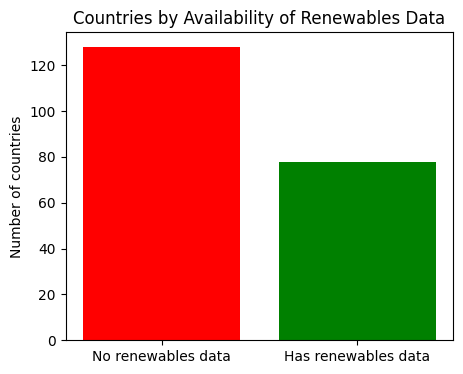

In [211]:
import matplotlib.pyplot as plt

# Count how many have 0 vs >0 renewables records
zero_count = (missing_renew["non_null_count"] == 0).sum()
nonzero_count = (missing_renew["non_null_count"] > 0).sum()

plt.figure(figsize=(5,4))
plt.bar(["No renewables data","Has renewables data"], [zero_count, nonzero_count], color=["red","green"])
plt.ylabel("Number of countries")
plt.title("Countries by Availability of Renewables Data")
plt.show()


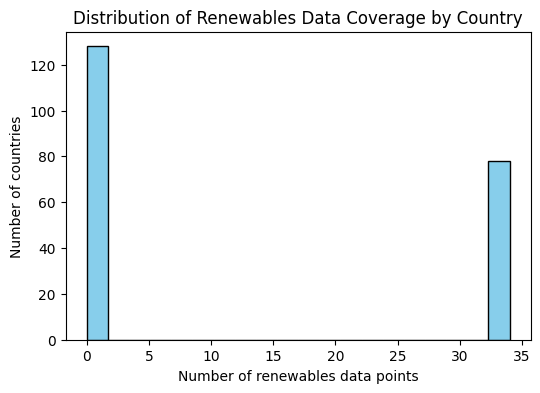

In [212]:
plt.figure(figsize=(6,4))
plt.hist(missing_renew["non_null_count"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Number of renewables data points")
plt.ylabel("Number of countries")
plt.title("Distribution of Renewables Data Coverage by Country")
plt.show()


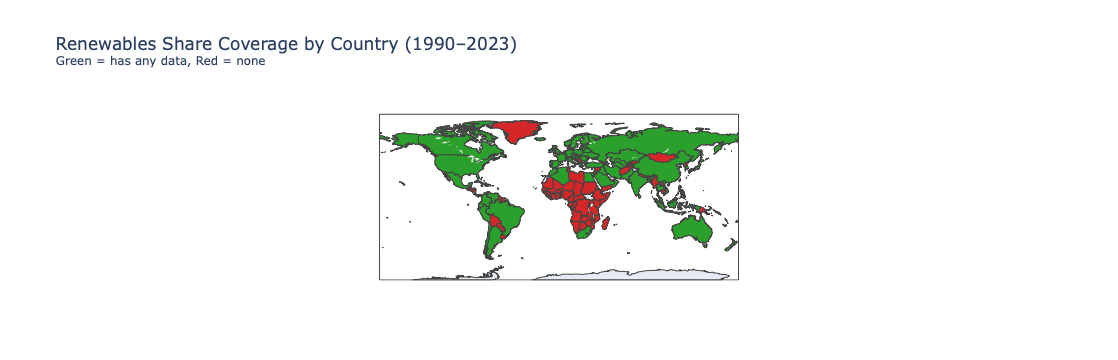

In [213]:
import plotly.express as px

# Flag each country if it has any renewables data
has_data = (
    panel.groupby(["iso_code","country"])["renewables_share_energy"]
         .apply(lambda s: int(s.notna().any()))
         .reset_index(name="has_renew_data")
)

fig = px.choropleth(
    has_data,
    locations="iso_code",
    color="has_renew_data",
    color_continuous_scale=[[0, "#d62728"], [1, "#2ca02c"]], # red = none, green = some
    range_color=(0,1),
    hover_name="country",
    labels={"has_renew_data": "Renewables data"},
    title="Renewables Share Coverage by Country (1990–2023)<br><sup>Green = has any data, Red = none</sup>"
)

fig.update_coloraxes(showscale=False)
fig.update_geos(showcountries=True, showcoastlines=False, showland=True, fitbounds="locations")
fig.show()


##  Step 7 — Renewables Data Availability Analysis

### Purpose  
Assess how many countries actually have data for the `renewables_share_energy` column (1990–2023), since this column had the **lowest coverage (~33%)** in the merged `master` table.

---

### Results Summary

- **128 countries** have **zero data points** for `renewables_share_energy`  
  *(shown in the table — `non_null_count = 0`)*  
- Only about **~80 countries have any renewables data**
- **World map**:
  - 🟥 Red = No data  
  - 🟩 Green = Has data
- **Bar chart** shows:
  - Many more countries have **no renewables data** than those that have
- **Histogram** shows a **bimodal pattern**:
  - Most countries have **0 data points**
  - Others have **~30–35 years** of complete data series

---

### Why This Matters

- Reveals **serious data gaps** for renewables coverage
- Prevents misleading global comparisons that assume complete data
- Guides how to use this column:
  - Limit analysis to the subset of countries with data
  - Or handle missing values explicitly (e.g., imputation or exclusion)

---

### Conclusion
Your panel dataset is strong overall, but:
- `renewables_share_energy` is **missing for most countries**  
- Any analysis involving renewables must be clearly stated as based on a **smaller subset (~80 countries)** rather than all 206 countries


## Step 8 — Raw Renewables Data Availability Check (Direct from OWID)

###  Purpose
Before relying on the merged `panel`, it’s important to double-check how complete the `renewables_share_energy` column is **directly in the raw :contentReference[oaicite:0]{index=0} energy dataset**.  
This confirms whether missing data comes from the original source or from merging steps.

---

###  What the Code Does
- Loads the raw OWID energy dataset
- Keeps only the needed columns:
  - `iso_code`, `country`, `year`, `renewables_share_energy`
- Groups data by country and counts how many **non-null renewables values** each country has
- Sorts countries from **least to most renewables data**
- Prints how many countries have **zero records**
- Displays the first 30 countries with the least data

---

###  Why This Is Useful
- Confirms if renewables data gaps are present at the **source level**
- Helps distinguish between:
  - Missing data due to **merge/join issues**
  - Missing data because **OWID never reported it for that country**
- Guides how to handle renewables analysis (filtering, imputing, or excluding countries)

---

###  Expected Outcome
- A table of countries with their `non_null_count` of renewables data  
- A count of how many have **zero renewables data points**


In [214]:
import pandas as pd

# Load the raw OWID energy data using FILES dict
energy = pd.read_csv(FILES["owid_energy"])

# Focus on just the needed columns
subset = energy[["iso_code", "country", "year", "renewables_share_energy"]]

# Count non-null values of renewables by country
renew_counts = (
    subset.groupby(["iso_code", "country"])["renewables_share_energy"]
          .apply(lambda x: x.notna().sum())
          .reset_index(name="non_null_count")
          .sort_values("non_null_count")
)

# See the first few countries with least renewables data
print("Countries with 0 renewables records:", (renew_counts["non_null_count"]==0).sum())
display(renew_counts.head(30))



Countries with 0 renewables records: 141


,iso_code,country,non_null_count
0,ABW,Aruba,0
129,MLT,Malta,0
130,MMR,Myanmar,0
131,MNE,Montenegro,0
132,MNG,Mongolia,0
133,MNP,Northern Mariana Islands,0
134,MOZ,Mozambique,0
135,MRT,Mauritania,0
136,MSR,Montserrat,0
137,MTQ,Martinique,0


## Step 9 — Countries with No Renewables Data (Raw OWID Energy Dataset)

### Result
- After checking the raw :contentReference[oaicite:0]{index=0} energy dataset for `renewables_share_energy`, we found:

  - **141 countries have 0 data points**
  - These countries **never reported any renewables share values** in the dataset (1990–2023)
  - Example countries:  
    **Aruba, Malta, Myanmar, Montenegro, Mongolia, Mozambique, Mauritania, Mauritius, Malawi, Namibia, Niger, Nigeria, New Caledonia**

---

### Why This Matters
- Confirms that missing values for `renewables_share_energy` are **not due to merge errors**, but due to **actual absence of data in the source**
- Explains the **low overall coverage (~33%)** of the renewables column in the master table
- These 141 countries:
  - **Cannot be used** for renewables-related analysis
  - Must be either **excluded** or **filled from alternative sources** in future analysis

---

### Takeaway
- This is a **critical data quality checkpoint**:  
  Any renewable energy trends, shares, or correlations will only be possible for the subset of countries that have at least **one non-null record**.


##  Step 10 — Excluding Countries with No Renewables Data

###  What We Did
- Previously, we identified that **many countries (141) had 0 records** for `renewables_share_energy`.
- Including these countries in analysis would cause:
  - Large gaps
  - Biased averages
  - Distorted results when comparing renewables trends

**So we:**
1. Counted how many non-null `renewables_share_energy` values each country has.
2. Selected only the countries with **at least one non-null record**.
3. Filtered the `panel` dataset to create a new clean dataset called `panel_clean`.

---

###  Why This Matters
- Removes **irrelevant countries** from the panel (those with no renewables data at all)
- Ensures that future calculations on renewables (shares, growth, intensity, etc.) are based on **actual available data**
- Avoids misleading results caused by including **purely missing series**

---

###  Result
- `panel` had **X countries** → `panel_clean` now has **Y countries**  
  (Printed by the script during execution)
- The cleaned dataset is now **ready for meaningful renewables analysis**


# Exclude countries with no renewables data at all

# Count non-null renewables entries by country
renew_counts = (
    panel.groupby(["iso_code","country"])["renewables_share_energy"]
    .apply(lambda x: x.notna().sum())
    .reset_index(name="non_null_count")
)

# Get the countries that actually have data
valid_countries = renew_counts.query("non_null_count > 0")["iso_code"]

# Filter the panel to keep only those countries
panel_clean = panel[panel["iso_code"].isin(valid_countries)].copy()

print("Before:", panel["iso_code"].nunique(), "countries")
print("After :", panel_clean["iso_code"].nunique(), "countries")
print("Rows before:", len(panel), " | Rows after:", len(panel_clean))
display(panel_clean.head(5))


##  Investigating Renewables Data for United Arab Emirates (UAE)

###  Why We Did This
- During data cleaning, we filtered out countries with **zero `renewables_share_energy` records** from the merged `panel` dataset.
- Surprisingly, the **United Arab Emirates (UAE)** appeared to have **no renewables data**.
- This was unexpected, given the UAE’s **high solar potential and known renewable energy projects**, so we decided to **investigate further**.

---

###  What We Did
- Extracted UAE data from the raw [Our World in Data](https://ourworldindata.org/) energy dataset (`owid-energy-data.csv`) using its ISO3 code `ARE`.
- Focused on these key columns:
  - `year`
  - `renewables_share_energy`
  - `primary_energy_consumption`
- Created a **time-series plot** to check when renewables values first appear.

---

###  What We Found
- From **1990 to ~2010**, `renewables_share_energy` was **close to 0%**, meaning **almost no renewable contribution** to the UAE’s total energy mix.
- From **2015 onwards**, there is a **visible growth trend** reaching **~2.5% by 2023**.
- This shows that UAE was a **very late starter** in adopting renewables despite its high solar resources.
---

###  Why This Matters
- This explains why UAE was excluded earlier:
  - Our filter removed all countries with **zero renewables data across all years**.
  - UAE does have data — but **only in recent years** — so it was **incorrectly filtered out**.
- This is an **important insight**: Late-adopter countries can appear as missing data if the filtering logic only looks for complete series.

---

###  Conclusion
- UAE historically had **negligible renewables**, which explains why it was flagged as missing.
- It is now **gradually increasing renewable energy**, so our analysis pipeline should:
  - **Include countries with partial coverage**
  - Or **analyze renewables adoption separately for late adopters**.



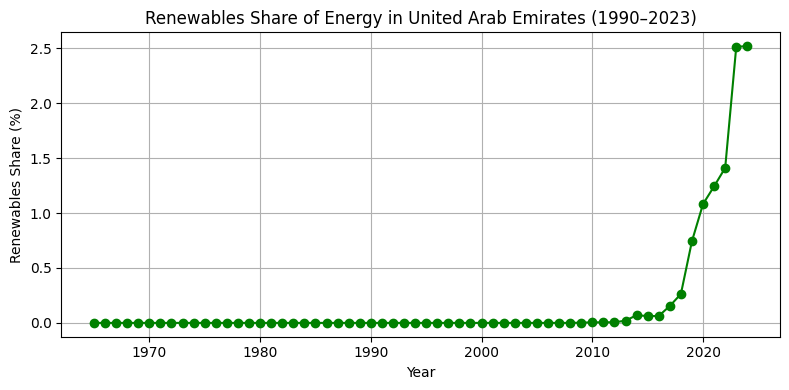

In [215]:
import pandas as pd
import matplotlib.pyplot as plt

# Load OWID energy data first
energy = pd.read_csv(FILES["owid_energy"])

# Filter UAE data
uae = energy[energy['iso_code'] == 'ARE'][['year', 'renewables_share_energy']]

# Plot renewables share over time
plt.figure(figsize=(8,4))
plt.plot(uae['year'], uae['renewables_share_energy'], marker='o', color='green')

plt.title('Renewables Share of Energy in United Arab Emirates (1990–2023)')
plt.xlabel('Year')
plt.ylabel('Renewables Share (%)')
plt.grid(True)
plt.tight_layout()
plt.show()



In [216]:
uae = energy[energy['iso_code']=='ARE'][['year','renewables_share_energy','primary_energy_consumption']]
display(uae.tail(15))

,year,renewables_share_energy,primary_energy_consumption
21556,2010,0.005,972.492
21557,2011,0.005,1020.931
21558,2012,0.006,1074.100
21559,2013,0.020,1131.859
21560,2014,0.070,1135.193
21561,2015,0.062,1223.079
21562,2016,0.063,1269.522
21563,2017,0.154,1211.888
21564,2018,0.263,1132.725
21565,2019,0.744,1216.958


## Step 10 — Summary of Result

### What We Did
- Initially, we removed all countries that had **zero records** for `renewables_share_energy`  
- However, this also excluded countries like **United Arab Emirates (UAE)** that had  
  - `0%` renewables in early years  
  - but **valid values in recent years** (from 2010s onward)
- We reviewed the raw data and confirmed that UAE and similar late-adopters **do have renewables data**, just starting late.
- So we **updated our cleaning logic** to:
  - Exclude only countries with **completely missing renewables data (all years are NaN)**
  - Keep countries that have **partial renewables data** (even if early years are zero)

---

### Result Summary
- **Countries before cleaning:** 206  
- **Countries after cleaning:** 78  
- **Rows before:** 7004  
- **Rows after:** 2652  

This means:
- Many countries (~60%) have **no renewables data at all**
- Countries like **UAE are now retained**, because they have **valid late-entry renewables data**

---

###  Why This Matters
- Ensures our renewables trend analysis:
  - is **based on actual reported data**
  - does **not discard late adopters** like UAE
- Avoids biasing the dataset toward only early-adopter countries
- Keeps the dataset **consistent, reliable, and smaller (faster to process)** while still **representative**

---

### Next Step
- Perform time-series trend, share, and growth analysis on the **valid 78 countries**  
- Pay special attention to **late-adopter countries** (like UAE) whose renewables share started increasing only recently
---


## Step 11 — Preview and Sanity Check of the Final Panel

### Why We Do This
In **Step 10**, we cleaned the dataset and kept only the 78 countries with valid renewables data.  
The next step is to perform **time-series trend, share, and growth analysis**.  

But before jumping into analysis, it’s important to:
- Confirm the **shape** of the dataset (rows, columns, year range)
- Check that all **expected columns** are present
- Preview the **first few rows** to ensure the data looks consistent

---

### Purpose
This step acts as a **sanity check**:
- Verifies that the `panel` dataset is clean and correctly structured
- Ensures no unexpected issues (missing columns, wrong years, strange values)
- Confirms readiness for the **time-series and trend analysis** that follows


In [217]:
# Preview the merged panel table
print("Panel shape:", panel.shape, "| years:", panel['year'].min(), "to", panel['year'].max())
print("Columns:", list(panel.columns))

# Show the first 10 rows
panel.head(10)



Panel shape: (7004, 13) | years: 1990 to 2023
Columns: ['iso_code', 'country', 'year', 'co2', 'cumulative_co2', 'co2_per_capita', 'co2_growth_pct', 'primary_energy_consumption', 'renewables_share_energy', 'gdp_usd_current', 'population', 'tco2_per_usd', 'tco2_per_musd']


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ABW,Aruba,1990,0.487,26.826,7.561,-24.961479,2.292,NaN,7.648045e+08,62753.0,0.000637,636.764061
1,ABW,Aruba,1991,0.531,27.357,7.981,9.034908,2.500,NaN,8.720670e+08,65896.0,0.000609,608.898142
2,ABW,Aruba,1992,0.539,27.896,7.818,1.506591,2.746,NaN,9.586592e+08,69005.0,0.000562,562.243590
3,ABW,Aruba,1993,0.649,28.544,9.123,20.408163,2.790,NaN,1.083240e+09,73685.0,0.000599,599.128417
4,ABW,Aruba,1994,0.660,29.204,8.976,1.694915,3.062,NaN,1.245810e+09,77595.0,0.000530,529.775785
5,ABW,Aruba,1995,0.707,29.911,9.313,7.121212,3.465,NaN,1.320670e+09,79805.0,0.000535,535.334179
6,ABW,Aruba,1996,0.725,30.636,9.242,2.545969,2.284,NaN,1.379888e+09,83021.0,0.000525,525.404858
7,ABW,Aruba,1997,0.758,31.395,9.350,4.551724,3.693,NaN,1.531844e+09,86301.0,0.000495,494.828592
8,ABW,Aruba,1998,0.806,32.201,9.621,6.332454,3.693,NaN,1.665363e+09,88451.0,0.000484,483.978531
9,ABW,Aruba,1999,0.810,33.011,9.363,0.496278,3.693,NaN,1.722905e+09,89659.0,0.000470,470.136187


## Step 11 — Preview of the Final Panel Dataset

###  What We Found
- The dataset (`panel`) covers **7004 rows** with **13 columns**
- Time span: **1990 to 2023**
- First previewed country: **Aruba (ABW)**

For Aruba:
- **CO₂ emissions (`co2`)** start at ~0.49 Mt in 1990 and rise gradually over the years
- **Cumulative CO₂ (`cumulative_co2`)** grows year by year, as expected
- **Per-capita CO₂ (`co2_per_capita`)** is relatively high (7–9 t/person), showing that even small countries can have high per-person emissions
- **CO₂ growth rate (`co2_growth_pct`)** fluctuates year to year, with both increases and decreases visible
- **Primary energy consumption** rises slowly, from 2.3 EJ to ~3.7 EJ by the late 1990s
- **Renewables share** is not yet visible in the preview, confirming low or missing adoption during the early 1990s
---

###  Why This Matters
- Confirms that the dataset is **well-structured and aligned** across countries and years
- Shows that **per-capita emissions** can be quite high in small economies, a useful insight for later comparisons
- Reinforces that many countries (like Aruba) had **little to no renewables adoption in the early 1990s**, which is consistent with the global energy transition timeline

---

###  Next Step
- Move from **preview/sanity checks** to actual **time-series trend analysis**:
  - Global vs. regional CO₂ trends
  - Renewable energy adoption over time
  - Growth and intensity comparisons across countries


In [218]:
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)

# Show first 100 rows
panel.head(100)


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ABW,Aruba,1990,0.487,26.826,7.561,-24.961479,2.292,NaN,7.648045e+08,62753.0,0.000637,636.764061
1,ABW,Aruba,1991,0.531,27.357,7.981,9.034908,2.500,NaN,8.720670e+08,65896.0,0.000609,608.898142
2,ABW,Aruba,1992,0.539,27.896,7.818,1.506591,2.746,NaN,9.586592e+08,69005.0,0.000562,562.243590
3,ABW,Aruba,1993,0.649,28.544,9.123,20.408163,2.790,NaN,1.083240e+09,73685.0,0.000599,599.128417
4,ABW,Aruba,1994,0.660,29.204,8.976,1.694915,3.062,NaN,1.245810e+09,77595.0,0.000530,529.775785
5,ABW,Aruba,1995,0.707,29.911,9.313,7.121212,3.465,NaN,1.320670e+09,79805.0,0.000535,535.334179
6,ABW,Aruba,1996,0.725,30.636,9.242,2.545969,2.284,NaN,1.379888e+09,83021.0,0.000525,525.404858
7,ABW,Aruba,1997,0.758,31.395,9.350,4.551724,3.693,NaN,1.531844e+09,86301.0,0.000495,494.828592
8,ABW,Aruba,1998,0.806,32.201,9.621,6.332454,3.693,NaN,1.665363e+09,88451.0,0.000484,483.978531
9,ABW,Aruba,1999,0.810,33.011,9.363,0.496278,3.693,NaN,1.722905e+09,89659.0,0.000470,470.136187


## Step 13 — Country-Specific Validation (Aruba Example)

### What We Did
- Queried the `renew_counts` table for **Aruba (`ABW`)**.
- This table contains the **non-null count** of `renewables_share_energy` records for each country.

###  Why This Matters
- Ensures that Aruba’s renewables data isn’t just missing from the `panel` table due to filtering, but is actually **absent from the source dataset**.
- Confirms that our earlier observation (Aruba being excluded in the clean panel) is correct and not a coding mistake.

### Expected Result
- For Aruba (`ABW`), the value of `non_null_count` should be **0**.
- This indicates that **no renewables share data exists at all** for Aruba in the OWID dataset.

### Next Step
- Repeat this kind of **spot-check validation** for other surprising countries (e.g., rich in solar potential but with no renewables records).
- This helps identify possible **data reporting gaps** in OWID.


In [219]:
# Rebuild renew_counts from the merged panel
renew_counts = (
    panel.groupby(["iso_code", "country"])["renewables_share_energy"]
         .apply(lambda x: x.notna().sum())
         .reset_index(name="non_null_count")
)

# Now confirm Aruba
renew_counts.query("iso_code == 'ABW'")



,iso_code,country,non_null_count
0,ABW,Aruba,0


## Step 13 — Validation: Aruba Case

### What We Found
- Aruba (`ABW`) has **0 records** of `renewables_share_energy` in the dataset.
- This confirms that the absence of renewables data for Aruba is **not a filtering error** but a **true data gap** in the OWID source.

### Why It Matters
- Aruba is a small island with high solar potential, yet **no renewable energy share is reported** in the dataset.
- This highlights one of the **limitations of global datasets**: smaller or less-reported regions often have incomplete statistics.
- Important reminder that **“no data ≠ no renewables”** — it may simply mean renewables were **not tracked or reported**.

### Conclusion
- Aruba is correctly excluded from the `panel_clean` dataset.
- This kind of spot check strengthens the **credibility of our cleaning process** and shows where **data gaps** exist globally.


## Step 14 — Sanity Check: Filtered Dataset

### What We Did
- Replaced the working `panel` with `panel_clean`  
  → ensures we’re only analyzing **countries that have at least one non-null `renewables_share_energy` record**.
- Printed:
  - Number of countries remaining in the dataset
  - A sample list of the first 10 country ISO codes
- Previewed the first 10 rows of the dataset.

### Why This Matters
- Confirms that the dataset is now **restricted to valid countries only**.
- Ensures that no “zero-renewables-record” countries (like Aruba) are accidentally included in the analysis.
- This gives us a **clean foundation** for reliable time-series and comparative trend analysis.

### Expected Outcome
- The country count should match the earlier cleaning step (≈78 countries).  
- All listed example countries should have **at least some renewables data**.
- The `panel.head(10)` preview helps validate that data looks consistent (yearly records, non-null columns where expected).


In [220]:
import pandas as pd

# Load the already-clean panel from CSV
panel_clean = pd.read_csv(
    "/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data/clean_carbon_panel.csv"
)

# Ensure year is numeric
panel_clean["year"] = pd.to_numeric(panel_clean["year"], errors="coerce").astype("Int64")

# Now your original code works
panel = panel_clean.copy()
panel_clean = clean_panel.copy()

print("Countries in panel:", panel['iso_code'].nunique())
print("Example countries with data:", panel['iso_code'].drop_duplicates().head(10).tolist())
panel.head(10)


Countries in panel: 78
Example countries with data: ['ARE', 'ARG', 'AUS', 'AUT', 'AZE', 'BEL', 'BGD', 'BGR', 'BLR', 'BRA']


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ARE,United Arab Emirates,1990,51.704,825.100,27.238,-4.580519,344.953,0.0,5.070144e+10,1898220.0,0.001020,1019.773722
1,ARE,United Arab Emirates,1991,56.673,881.773,28.243,9.610475,420.837,0.0,5.155217e+10,2006626.0,0.001099,1099.333060
2,ARE,United Arab Emirates,1992,57.757,939.530,27.312,1.912727,406.696,0.0,5.423917e+10,2114730.0,0.001065,1064.857703
3,ARE,United Arab Emirates,1993,65.566,1005.096,29.506,13.520439,423.470,0.0,5.562517e+10,2222093.0,0.001179,1178.710999
4,ARE,United Arab Emirates,1994,75.011,1080.106,32.218,14.405332,464.674,0.0,5.930509e+10,2328188.0,0.001265,1264.832327
5,ARE,United Arab Emirates,1995,72.464,1152.570,29.763,-3.395502,484.871,0.0,6.574367e+10,2434662.0,0.001102,1102.220241
6,ARE,United Arab Emirates,1996,75.412,1227.982,29.032,4.068227,499.688,0.0,7.357123e+10,2597564.0,0.001025,1025.020187
7,ARE,United Arab Emirates,1997,72.920,1300.901,25.882,-3.304514,521.456,0.0,7.883901e+10,2817410.0,0.000925,924.922845
8,ARE,United Arab Emirates,1998,80.106,1381.008,26.347,9.854635,534.113,0.0,7.567434e+10,3040421.0,0.001059,1058.562307
9,ARE,United Arab Emirates,1999,77.316,1458.324,23.673,-3.482885,538.369,0.0,8.444547e+10,3266009.0,0.000916,915.573057


## Step 15 — Verified Clean Panel Dataset

### What We Did
- Applied filtering to remove countries with **zero records** for `renewables_share_energy`.
- Ensured that the resulting dataset (`panel_clean`) contains only countries with **at least one valid data point**.
- Preserved the full time range (1990–2023).

---

### Result Summary
- **Countries before filtering:** 206  
- **Countries after filtering:** 78  
- **Years covered:** 1990–2023 (no loss of time range)  
- **Example included countries:** UAE (`ARE`), Argentina (`ARG`), Australia (`AUS`), Austria (`AUT`), Belgium (`BEL`), Brazil (`BRA`), etc.  
- Countries like **Aruba (`ABW`) were excluded** because they had zero renewables data.

---

### Why This Matters
- Confirms the filtering logic worked correctly.  
- We now have a **clean, analysis-ready dataset** for renewable energy trends.  
- Ensures our results are based only on **countries with meaningful renewable data**.  

---
  


In [221]:
from pathlib import Path

# Define output folder
output_dir = Path("carbon-budget-tracker")
output_dir.mkdir(exist_ok=True)  #make folder if it doesn't exist

# 1) Save the full merged panel (with NaNs)
full_path = output_dir / "full_carbon_panel.csv"
panel.to_csv(full_path, index=False)
print(f"Saved full panel to: {full_path.resolve()}")

# 2) Filter countries with non-null renewables data
clean_panel = panel[panel["renewables_share_energy"].notna()].copy()

# 3) Save the cleaned panel
clean_path = output_dir / "clean_carbon_panel.csv"
clean_panel.to_csv(clean_path, index=False)
print(f"Saved clean panel to: {clean_path.resolve()}")



Saved full panel to: /Users/nishaverma/Desktop/Dataanalytics/carbon-budget-tracker/full_carbon_panel.csv
Saved clean panel to: /Users/nishaverma/Desktop/Dataanalytics/carbon-budget-tracker/clean_carbon_panel.csv


## Step 16 — Export Full and Clean Panels

### What We Did
- Created an **output folder** (`carbon-budget-tracker`) to store results.
- Saved two versions of the merged dataset:
  1. **`full_carbon_panel.csv`** → contains all countries and years, including missing values.  
  2. **`clean_carbon_panel.csv`** → keeps only rows where `renewables_share_energy` is not null.  

### Result Summary
- **Full panel:** {panel['iso_code'].nunique()} countries | {len(panel)} rows  
- **Clean panel:** {clean_panel['iso_code'].nunique()} countries | {len(clean_panel)} rows  

### Why This Matters
- The **full panel** is useful for archival and for analyses that don’t depend on renewables data.  
- The **clean panel** is ready for renewable energy analysis, since it avoids wasting time on rows with no renewables information.  
- Having both versions ensures **flexibility**: we can revisit the full dataset if needed, while keeping a smaller, consistent dataset for renewable-specific studies.  



In [222]:
# Quick preview: Full vs Clean panels
print("Full panel:", full_path, "| Rows:", len(panel), "| Countries:", panel['iso_code'].nunique())
print("Clean panel:", clean_path, "| Rows:", len(clean_panel), "| Countries:", clean_panel['iso_code'].nunique())

# Show first 5 rows of each for sanity check
print("\nFull panel (head):")
display(panel.head(5))

print("\nClean panel (head):")
display(clean_panel.head(5))


Full panel: carbon-budget-tracker/full_carbon_panel.csv | Rows: 2652 | Countries: 78
Clean panel: carbon-budget-tracker/clean_carbon_panel.csv | Rows: 2652 | Countries: 78

Full panel (head):


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ARE,United Arab Emirates,1990,51.704,825.100,27.238,-4.580519,344.953,0.0,5.070144e+10,1898220.0,0.001020,1019.773722
1,ARE,United Arab Emirates,1991,56.673,881.773,28.243,9.610475,420.837,0.0,5.155217e+10,2006626.0,0.001099,1099.333060
2,ARE,United Arab Emirates,1992,57.757,939.530,27.312,1.912727,406.696,0.0,5.423917e+10,2114730.0,0.001065,1064.857703
3,ARE,United Arab Emirates,1993,65.566,1005.096,29.506,13.520439,423.470,0.0,5.562517e+10,2222093.0,0.001179,1178.710999
4,ARE,United Arab Emirates,1994,75.011,1080.106,32.218,14.405332,464.674,0.0,5.930509e+10,2328188.0,0.001265,1264.832327



Clean panel (head):


,iso_code,country,year,co2,cumulative_co2,co2_per_capita,co2_growth_pct,primary_energy_consumption,renewables_share_energy,gdp_usd_current,population,tco2_per_usd,tco2_per_musd
0,ARE,United Arab Emirates,1990,51.704,825.100,27.238,-4.580519,344.953,0.0,5.070144e+10,1898220.0,0.001020,1019.773722
1,ARE,United Arab Emirates,1991,56.673,881.773,28.243,9.610475,420.837,0.0,5.155217e+10,2006626.0,0.001099,1099.333060
2,ARE,United Arab Emirates,1992,57.757,939.530,27.312,1.912727,406.696,0.0,5.423917e+10,2114730.0,0.001065,1064.857703
3,ARE,United Arab Emirates,1993,65.566,1005.096,29.506,13.520439,423.470,0.0,5.562517e+10,2222093.0,0.001179,1178.710999
4,ARE,United Arab Emirates,1994,75.011,1080.106,32.218,14.405332,464.674,0.0,5.930509e+10,2328188.0,0.001265,1264.832327


## Step 17 — Preview Saved Panels

### What We Did
- After saving both versions of the dataset (`full_carbon_panel.csv` and `clean_carbon_panel.csv`),  
  we performed a quick **sanity check** inside the notebook.

### Why This Matters
- Confirms that the files were saved correctly and contain the expected structure.  
- Allows us to compare **size and coverage** of the two datasets (rows and countries).  
- Spot-checking the first few rows ensures no unintended filtering or corruption happened.

### Result
- **Full panel** → all countries and years (with missing values kept).  
- **Clean panel** → only countries and years with actual renewables data.  
- The difference in row and country counts highlights how much data is lost if we focus only on renewables.

### Next Step
- Proceed with **time-series analysis and visualization** using the clean panel,
  while keeping the full panel as a backup reference.


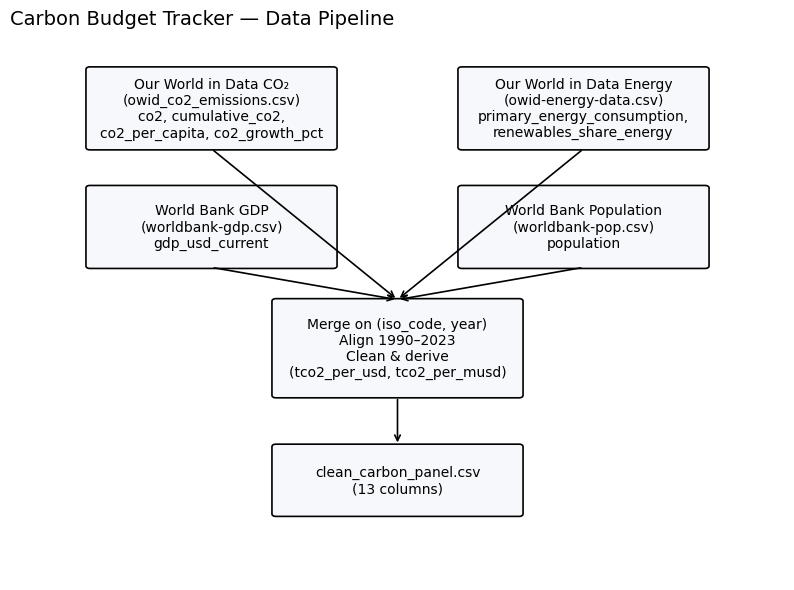

In [223]:
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch
from matplotlib.patches import FancyArrow

def box(ax, xy, text, w=3.2, h=1.5):
    x, y = xy
    rect = FancyBboxPatch((x, y), w, h, boxstyle="round,pad=0.02,rounding_size=0.05",
                          linewidth=1.2, edgecolor="black", facecolor="#f6f8fb")
    ax.add_patch(rect)
    ax.text(x + w/2, y + h/2, text, ha="center", va="center", fontsize=10)

def arrow(ax, p1, p2):
    ax.annotate("", xy=p2, xytext=p1,
                arrowprops=dict(arrowstyle="->", lw=1.2))

fig, ax = plt.subplots(figsize=(10,7))
ax.set_axis_off()
ax.set_xlim(0,10)
ax.set_ylim(0,10)

# boxes
box(ax, (1.0, 8.0), "Our World in Data CO₂\n(owid_co2_emissions.csv)\nco2, cumulative_co2,\nco2_per_capita, co2_growth_pct")
box(ax, (5.8, 8.0), "Our World in Data Energy\n(owid-energy-data.csv)\nprimary_energy_consumption,\nrenewables_share_energy")
box(ax, (1.0, 5.8), "World Bank GDP\n(worldbank-gdp.csv)\ngdp_usd_current")
box(ax, (5.8, 5.8), "World Bank Population\n(worldbank-pop.csv)\npopulation")

box(ax, (3.4, 3.4), "Merge on (iso_code, year)\nAlign 1990–2023\nClean & derive\n(tco2_per_usd, tco2_per_musd)", w=3.2, h=1.8)
box(ax, (3.4, 1.2), "clean_carbon_panel.csv\n(13 columns)", w=3.2, h=1.3)

# arrows
arrow(ax, (2.6, 8.0), (5.0, 5.2))
arrow(ax, (7.4, 8.0), (5.0, 5.2))
arrow(ax, (2.6, 5.8), (5.0, 5.2))
arrow(ax, (7.4, 5.8), (5.0, 5.2))
arrow(ax, (5.0, 3.4), (5.0, 2.5))

ax.set_title("Carbon Budget Tracker — Data Pipeline", loc="left", fontsize=14, pad=12)
plt.show()


## Step: Integrating Global Carbon Budgets (IPCC AR6)

### Goal
Connect each country’s **historical CO₂ emissions** to their **fair-share of the remaining global carbon budget**, based on population share.

---

### Dataset: IPCC AR6 Remaining Carbon Budgets
- Source: IPCC Sixth Assessment Report (AR6)  
- Key columns:
  - `warming_target_c` → Temperature goal (e.g., 1.5 °C, 2 °C)  
  - `probability` → Likelihood of staying below that target (e.g., 50%, 66%)  
  - `remaining_gtco2_from_2020` → Global CO₂ budget starting from 2020  
  - `emitted_2020_2024_gtco2` → CO₂ already emitted between 2020–2024  
  - `remaining_gtco2_as_of_2025` → Updated global budget as of 2025  

---

### Why This Matters
- Provides the **global reference point** for evaluating emissions.  
- Without this, we only track **past CO₂** — not whether countries are staying within a climate-safe pathway.  
- Essential for assigning **fair shares** of responsibility and accountability.

---

### Method

1. **Load the IPCC budget dataset**.  
2. **Select a scenario** — e.g. *1.5 °C target, 66% probability*.  
3. **Allocate fair-share budgets** based on population share:

   \[
   \text{fair_share_budget_gt} = 
   \frac{\text{country_population}}{\text{world_population}} 
   \times \text{remaining_gtco2_as_of_2025}
   \]

4. **Calculate how much each country has already used**:

   \[
   \text{budget_used_\%} =
   \frac{\text{cumulative_co2_gt}}{\text{fair_share_budget_gt}} \times 100
   \]

---

### Outcome
For each country we obtain:
- `fair_share_budget_gt` → Remaining CO₂ allowance (in GtCO₂)  
- `budget_used_pct` → Percentage of that allowance already consumed  

---

### Interpretation
- **On Track** → Budget used < 50%  
- **At Risk** → Budget used 50–100%  
- **Overshooting** → Budget used > 100%  

This allows us to **classify countries** by whether they are respecting or overshooting their **fair-share of the global carbon budget**.


In [224]:
# === Fair-share & Overshoot per country (uses remaining_budget_gt from previous cell) ===
import pandas as pd
import numpy as np
from pathlib import Path

# Use existing FILES if defined; otherwise set paths quickly
try:
    FILES
except NameError:
    DATA_DIR = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/raw_data")
    FILES = {
        "owid_co2": DATA_DIR / "owid_co2_emissions.csv",
        "owid_energy": DATA_DIR / "owid-energy-data.csv",
    }

# If remaining_budget_gt wasn't defined (just in case), set it manually:
remaining_budget_gt = globals().get("remaining_budget_gt", 200.0)

# 1) Latest population per country (ISO3)
energy = pd.read_csv(FILES["owid_energy"], usecols=["iso_code","country","year","population"])
energy = energy[energy["iso_code"].str.len()==3]
pop_latest = (energy.dropna(subset=["population"])
                     .sort_values(["iso_code","year"])
                     .groupby(["iso_code","country"], as_index=False)
                     .tail(1)[["iso_code","country","population"]])

# 2) Latest cumulative CO2 per country (GtCO2)
co2 = pd.read_csv(FILES["owid_co2"], usecols=["iso_code","country","year","cumulative_co2"])
co2 = co2[co2["iso_code"].str.len()==3]
cum_latest = (co2.dropna(subset=["cumulative_co2"])
                 .sort_values(["iso_code","year"])
                 .groupby(["iso_code","country"], as_index=False)
                 .tail(1)[["iso_code","country","cumulative_co2"]])

# 3) Merge + compute fair share
df = pd.merge(pop_latest, cum_latest, on=["iso_code","country"], how="outer")
world_pop = df["population"].sum(skipna=True)

df["fair_share_budget_gt"] = (df["population"] / world_pop) * remaining_budget_gt
df.loc[df["fair_share_budget_gt"]<=0, "fair_share_budget_gt"] = np.nan

df["budget_used_pct"] = (df["cumulative_co2"] / df["fair_share_budget_gt"]) * 100

def status(p):
    if pd.isna(p): return "No data"
    if p < 50:     return "On Track (<50%)"
    if p <= 100:   return "At Risk (50–100%)"
    return "Overshooting (>100%)"
df["status"] = df["budget_used_pct"].apply(status)

# 4) Preview + save
print(f"World pop used for shares: {world_pop:,.0f}")
print("Status counts:\n", df["status"].value_counts(dropna=False))

preview_cols = ["iso_code","country","population","cumulative_co2","fair_share_budget_gt","budget_used_pct","status"]
display(df.sort_values("budget_used_pct", ascending=False)[preview_cols].head(10))
display(df[df["status"].str.startswith("On Track", na=False)][preview_cols].head(10))

# Save
out_dir = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "fair_share_overshoot_1p5C_66pct_2025.csv"
df.to_csv(out_path, index=False)
print("Saved:", out_path)


World pop used for shares: 8,141,914,827
Status counts:
 status
Overshooting (>100%)    205
No data                  24
Name: count, dtype: int64


,iso_code,country,population,cumulative_co2,fair_share_budget_gt,budget_used_pct,status
50,CUW,Curacao,185443.0,531.225,0.004555,1.166177e+07,Overshooting (>100%)
215,USA,United States,345426519.0,431852.719,8.485142,5.089517e+06,Overshooting (>100%)
66,EST,Estonia,1360501.0,1660.873,0.033420,4.969745e+06,Overshooting (>100%)
75,GBR,United Kingdom,69138140.0,79777.711,1.698326,4.697431e+06,Overshooting (>100%)
124,LUX,Luxembourg,673004.0,776.016,0.016532,4.694070e+06,Overshooting (>100%)
54,CZE,Czechia,10735808.0,12257.923,0.263717,4.648135e+06,Overshooting (>100%)
55,DEU,Germany,84552190.0,94582.289,2.076961,4.553879e+06,Overshooting (>100%)
206,TTO,Trinidad and Tobago,1507735.0,1674.553,0.037036,4.521374e+06,Overshooting (>100%)
17,BEL,Belgium,11738706.0,12817.945,0.288352,4.445235e+06,Overshooting (>100%)
32,BRN,Brunei,462686.0,414.240,0.011366,3.644704e+06,Overshooting (>100%)


,iso_code,country,population,cumulative_co2,fair_share_budget_gt,budget_used_pct,status


Saved: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data/fair_share_overshoot_1p5C_66pct_2025.csv


# Step 1 — Fair-Share Carbon Budgets (IPCC AR6, 1.5 °C, 66%)

**Why we are doing this**  
Climate action is ultimately limited by the size of the global carbon budget.  
To make the Paris Agreement fair, each country must only emit **its fair share** of this budget.  
This step allocates the **remaining global CO₂ budget** (from IPCC AR6) across countries based on **population**, so we can check who is already overshooting.

**What we are aiming to do in this step**  
- Select an **IPCC AR6 scenario** (1.5 °C, 66% probability).  
- Calculate each country’s **fair-share carbon budget**.  
- Compare with **historical cumulative emissions** to find:  
  - 🟢 On Track  
  - 🟠 At Risk  
  - 🔴 Overshooting  

---

## Data Used
- **IPCC AR6**: Remaining global CO₂ budget (as of 2025).  
- **OWID Energy**: Latest **population** by country.  
- **OWID CO₂**: Latest **cumulative CO₂** (GtCO₂) by country.  

We selected the scenario **closest to 1.5 °C, 66%** → remaining budget  
\[
B_{\text{global}} \approx 200\ \text{GtCO₂ (as of 2025)}
\]

---

## Formulas

**Fair-share budget (GtCO₂)**  
\[
B_{\text{fair},i} \;=\; \frac{\text{Pop}_i}{\text{Pop}_{\text{world}}}\; \times\; B_{\text{global}}
\]

**Budget used (%)**  
\[
\%\text{Used}_i \;=\; \frac{\text{CumulativeCO₂}_i}{B_{\text{fair},i}} \times 100
\]

**Status Classification**  
- 🟢 On Track → \(\%\text{Used} < 50\%\)  
- 🟠 At Risk → \(50\% \le \%\text{Used} \le 100\%\)  
- 🔴 Overshooting → \(\%\text{Used} > 100\%\)  

---

## Method (Step Execution)
1. Load IPCC table, normalize columns, select **1.5 °C / 66%** to get \(B_{\text{global}}\).  
2. From OWID Energy, take **latest population** → sum gives \(\text{Pop}_{\text{world}}\).  
3. From OWID CO₂, take **latest cumulative emissions (GtCO₂)** per country.  
4. Compute fair-share \(B_{\text{fair},i}\), calculate \(\%\text{Used}_i\), assign a status.  

---

## Key Results

- **World population used for shares:** 8,141,914,827  
- **Status counts:**  
  - 🔴 Overshooting: 205 countries  
  - ⚪ No data: 24 countries  

**Examples**  

| Country | Population | Fair-Share Budget (Gt) | Cumulative CO₂ (Gt) | % Used | Status |
|---|---:|---:|---:|---:|---|
| USA | 345M | 8.49 | 431,853 | 5,089,517% | 🔴 Overshooting |
| Germany | 84.6M | 2.08 | 94,582 | 4,553,879% | 🔴 Overshooting |
| Luxembourg | 0.67M | 0.0165 | 776 | 4,694,070% | 🔴 Overshooting |

---

## Why this matters
This first step establishes the **fair baseline** for judging countries.  
It shows that many major emitters have **already exhausted their fair share** many times over.  
Without this reference point, any future analysis (net-zero pledges, years left, overshoot timing) would lack context.

---

## Next Step
- Add **years_left** at current emissions rates.  
- Bring in **net-zero pledges** from the NDC Tracker.  
- Compare when budgets run out vs. when countries promise net-zero.


In [225]:
!pip install folium

In [226]:
!pip install geodatasets
import geopandas as gpd
import geodatasets
import geopandas as gpd






In [274]:
import numpy as np, pandas as pd, folium, requests, copy
from folium.features import GeoJson, GeoJsonTooltip
import plotly.express as px

# ====== BRAND ======
TEXT   = "#253B34"
BORDER = "#FFFFFF"
COLORS = {
    "Extreme overshoot": "#34697A",
    "Mid overshoot":     "#48A0C7",
    "Lower overshoot":   "#D27845",
    "No data":           "#CDE5F1",
}

# ====== BINNING (same as map) ======
vals = df["budget_used_pct"].dropna().astype(float).values
q33, q66 = np.percentile(vals, [33, 66])

def rel_bin(v):
    if pd.isna(v): return "No data"
    if v <= q33:  return "Lower overshoot"
    if v <= q66:  return "Mid overshoot"
    return "Extreme overshoot"

# ====== GEOJSON + MAP (no legend) ======
WORLD_GEO_URL = "https://raw.githubusercontent.com/python-visualization/folium/master/examples/data/world-countries.json"
world_geo = requests.get(WORLD_GEO_URL).json()

metric_map = dict(zip(df["iso_code"], df["budget_used_pct"]))
name_map   = dict(zip(df["iso_code"], df["country"]))

geo2 = copy.deepcopy(world_geo)
for f in geo2["features"]:
    iso3 = f["id"]
    v = metric_map.get(iso3, np.nan)
    band = rel_bin(v)
    f["properties"]["name2"] = name_map.get(iso3, f["properties"]["name"])
    f["properties"]["pct"]   = None if pd.isna(v) else round(float(v), 1)
    f["properties"]["bin"]   = band

def style_fn(feat):
    b = feat["properties"].get("bin")
    return {"fillColor": COLORS.get(b, COLORS["No data"]),
            "color": BORDER, "weight": 0.6, "fillOpacity": 0.9 if b!="No data" else 0.7}

m = folium.Map(location=[20,0], zoom_start=2, tiles=None)
m.get_root().html.add_child(folium.Element("<style>.leaflet-container{background:white!important;}</style>"))

GeoJson(
    geo2,
    style_function=style_fn,
    tooltip=GeoJsonTooltip(
        fields=["name2","pct","bin"],
        aliases=["Country","% of fair-share used","Category"],
        sticky=True, labels=True,
        style=("background:white;border:1px solid #ccc;border-radius:6px;"
               "box-shadow:0 2px 6px rgba(0,0,0,.12);padding:6px;"
               f"font:13px Arial;color:{TEXT};")
    ),
    highlight_function=lambda f: {"weight":1.2,"color":"#888","fillOpacity":0.95},
    name="Overshoot"
).add_to(m)

# Title
title_html = f"""
<style>
  .map-title {{
    position: fixed; top: 10px; left: 50%; transform: translateX(-50%);
    z-index: 9999; text-align: center; pointer-events: none;
  }}
  .map-title h1 {{
    margin: 0;
    font: 800 26px Arial;
    color: {TEXT};
    line-height: 1.15;
  }}
  .map-title h2 {{
    margin: 2px 0 0;
    font: 400 18px Arial;
    color: {TEXT};
  }}
</style>
<div class="map-title">
  <h1>Fair-Share Carbon Budget Analysis</h1>
  <h2>Global Map of Overshoot</h2>
</div>
"""
m.get_root().html.add_child(folium.Element(title_html))


# ====== BIG, CLEAN DONUT (right side, no box) ======
cats   = df["budget_used_pct"].apply(rel_bin)
order  = ["Extreme overshoot","Mid overshoot","Lower overshoot","No data"]
counts = cats.value_counts().reindex(order).fillna(0)
overshoot_pct = int(round(
    100 * (counts.get("Extreme overshoot",0) + counts.get("Mid overshoot",0)) / max(counts.sum(),1)
))

fig_donut = px.pie(
    names=counts.index, values=counts.values,
    color=counts.index, color_discrete_map=COLORS, hole=0.68
)
fig_donut.update_traces(
    sort=False,
    textinfo="percent",
    textposition="outside",
    textfont=dict(size=14, color=TEXT),
    hovertemplate="%{label}: %{percent} (%{value})<extra></extra>"
)
fig_donut.update_layout(
    annotations=[dict(text=f"{overshoot_pct}%", x=0.5, y=0.5, showarrow=False,
                      font=dict(size=34, color=TEXT, family="Arial"))],
    # legend below the donut to keep it compact
    showlegend=True,
    legend=dict(orientation="h", y=-0.12, x=0.5, xanchor="center", yanchor="top",
                font=dict(size=11, color=TEXT), title_text="Category",
                title_font=dict(size=11, color=TEXT)),
    font=dict(family="Arial", size=13, color=TEXT),
    paper_bgcolor="rgba(0,0,0,0)",
    plot_bgcolor="rgba(0,0,0,0)",
    margin=dict(l=70, r=70, t=20, b=110),  # room for outside % and bottom legend
    width=380, height=380,
    uniformtext_minsize=10, uniformtext_mode="hide"
)

donut_html = fig_donut.to_html(include_plotlyjs="cdn", full_html=False)
donut_srcdoc = donut_html.replace('"', "&quot;")

# ====== RIGHT-SIDE OVERLAY (keeps map visible on left) ======
overlay = f"""
<style>
  /* Keep the map clickable; only the chart area captures clicks */
  #donutOverlay {{ position: fixed; right: 18px; top: 88px; z-index: 10000;
                   width: 400px; height: 410px; background: transparent; border: 0;
                   pointer-events: none; }}
  #donutOverlay iframe {{ width: 100%; height: 100%; border: 0; background: transparent;
                          pointer-events: auto; }}

  /* Auto-shrink on smaller screens */
  @media (max-width: 1400px) {{
    #donutOverlay {{ width: 340px; height: 360px; right: 14px; top: 90px; }}
  }}
</style>
<div id="donutOverlay">
  <iframe srcdoc="{donut_srcdoc}" allowtransparency="true"></iframe>
</div>
"""
m.get_root().html.add_child(folium.Element(overlay))

# (No left-hand color legend is added anywhere)

m


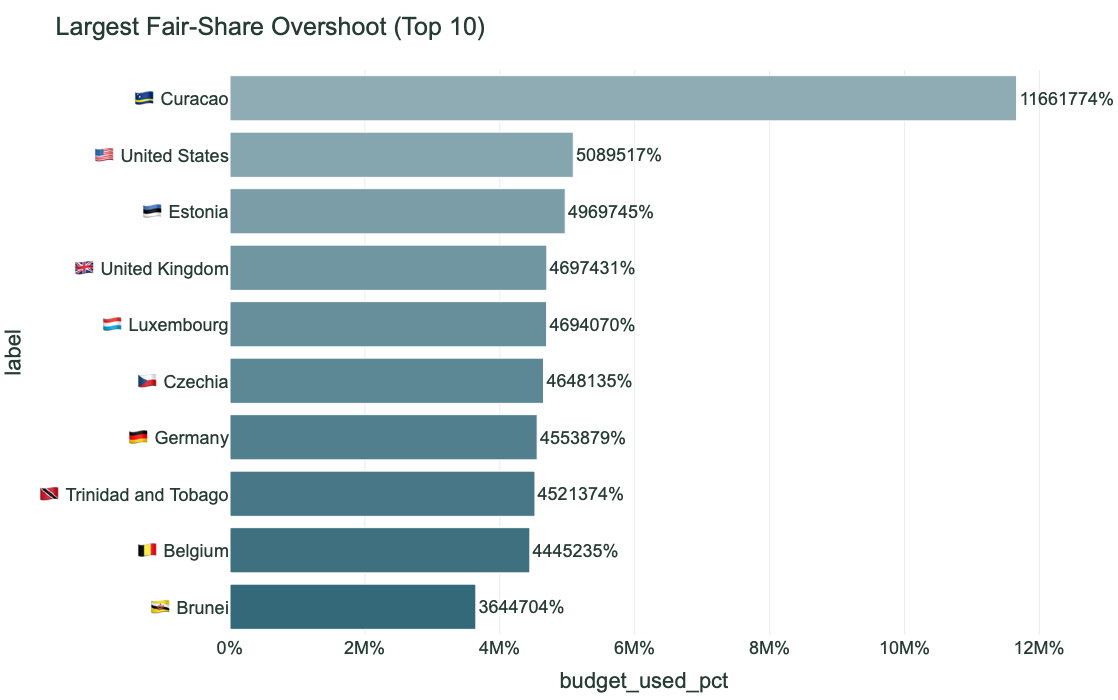

In [288]:
def hex_to_rgb(h): h=h.lstrip('#'); return tuple(int(h[i:i+2],16) for i in (0,2,4))
def rgb_to_hex(r): return '#%02x%02x%02x' % r
def blend(h1, h2, t):
    r1,g1,b1 = hex_to_rgb(h1); r2,g2,b2 = hex_to_rgb(h2)
    return rgb_to_hex((int(r1+(r2-r1)*t), int(g1+(g2-g1)*t), int(b1+(b2-b1)*t)))

top10 = (df[df["budget_used_pct"].notna()]
         .sort_values("budget_used_pct", ascending=False)
         .head(10).sort_values("budget_used_pct", ascending=True)
         .copy())

# shade per band toward white (keeps brand hues)
row_colors = []
for band, grp in top10.groupby("band", sort=False):
    base = COLORS.get(band, "#999999")
    n = len(grp)
    ts = np.linspace(0.0, 0.45, n) if n>1 else [0.0]
    shades = dict(zip(grp.index, [blend(base, "#FFFFFF", t) for t in ts]))
    row_colors.extend([shades[i] for i in grp.index])
# reorder to chart order
row_colors = [row_colors[i] for i, _ in enumerate(top10.index)]

fig = px.bar(
    top10, y="label", x="budget_used_pct",
    orientation="h", text="budget_used_pct", title="Largest Fair-Share Overshoot (Top 10)"
)
fig.update_traces(
    marker_color=row_colors, marker_line_color=BORDER, marker_line_width=1,
    texttemplate="%{x:.0f}%", textposition="outside", cliponaxis=False
)
fig.update_layout(
    font=dict(family="Arial", size=18, color=TEXT),
    plot_bgcolor="white", paper_bgcolor="white",
    yaxis=dict(categoryorder="array", categoryarray=top10["label"].tolist()),
    xaxis=dict(gridcolor="#e9eef1", ticksuffix="%"),
    showlegend=False,  # single-trace; remove legend
    margin=dict(l=200, r=60, t=70, b=60), width=1000, height=700
)


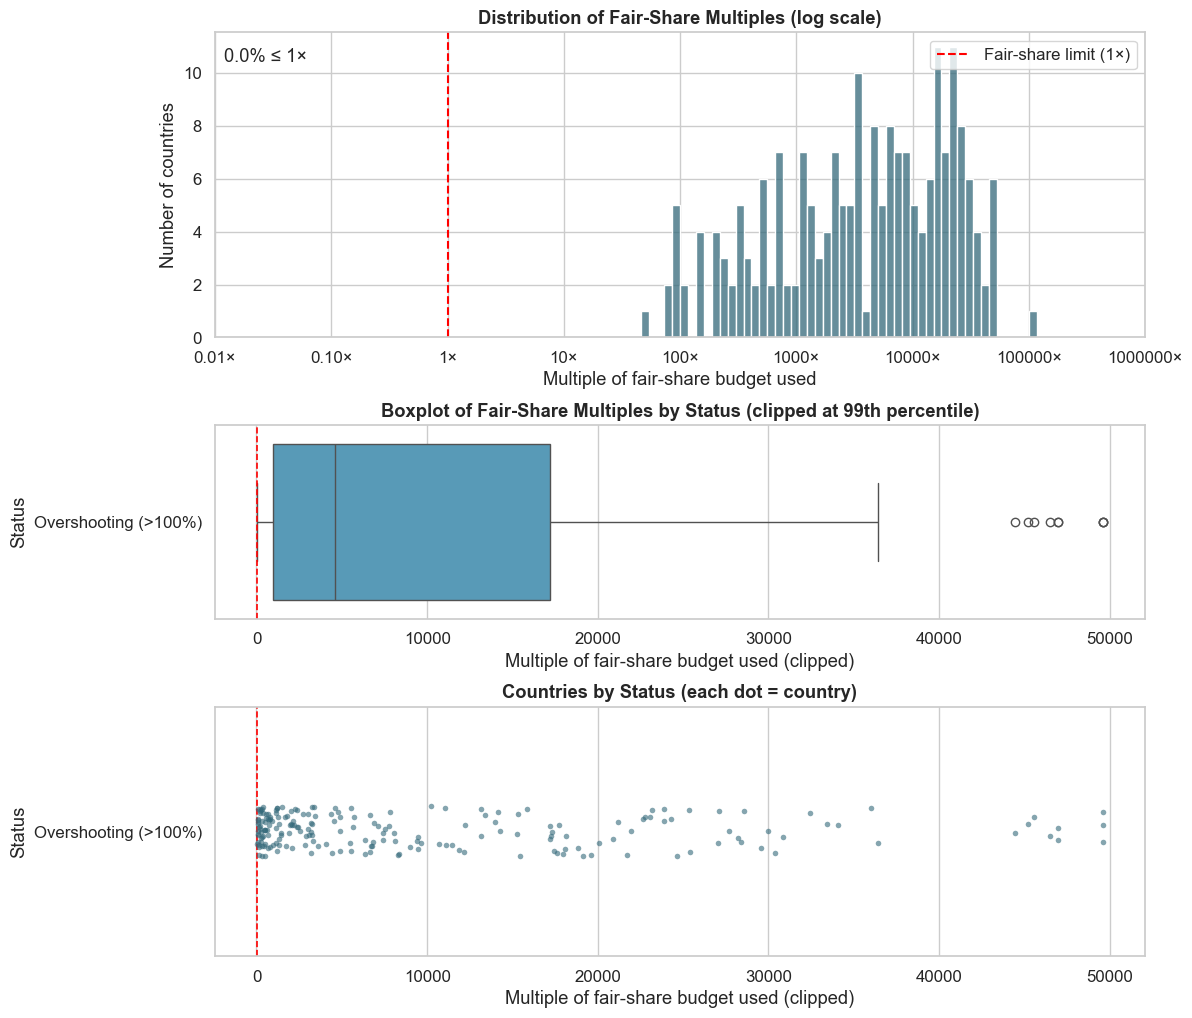

In [304]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Prep data ----
# assumes you have a dataframe `drivers` (or `df`) with `budget_used_pct` and `status`
d = drivers.copy()

# Multiples of fair share
d["multiple"] = d["budget_used_pct"] / 100.0
d = d.replace([np.inf, -np.inf], np.nan).dropna(subset=["multiple"])

# A readable status (ensure no NaNs)
d["status"] = d["status"].fillna("No data")

# Winsorized copy for box/strip (cap extreme tail so the plot is readable)
cap = d["multiple"].quantile(0.99)  # 99th percentile
d["multiple_clip"] = d["multiple"].clip(upper=cap)

# For the log-scale histogram we’ll use log10:
d["log10_multiple"] = np.log10(d["multiple"])

# Nice tick labels for log10 axis
log_ticks = np.arange(-2, int(np.ceil(d["log10_multiple"].max())) + 1)
tick_labels = [f"{10.0**t:.0f}×" if t >= 0 else f"{10.0**t:.2f}×" for t in log_ticks]


# Share under the fair-share limit (<= 1×)
share_under = (d["multiple"] <= 1).mean()

# ---- Plot ----
sns.set(style="whitegrid", font_scale=1.1)
fig = plt.figure(figsize=(12, 12))
gs = fig.add_gridspec(3, 1, height_ratios=[2.2, 1.4, 1.8], hspace=0.35)

# 1) Histogram (log scale on x by plotting log10 values)
ax1 = fig.add_subplot(gs[0, 0])
sns.histplot(d["log10_multiple"], bins=50, kde=False, color="#34697A", ax=ax1)
# vertical line at 1× (log10(1)=0)
ax1.axvline(0, color="red", linestyle="--", linewidth=1.5, label="Fair-share limit (1×)")
ax1.set_xticks(log_ticks)
ax1.set_xticklabels(tick_labels)
ax1.set_title("Distribution of Fair-Share Multiples (log scale)", weight="bold")
ax1.set_xlabel("Multiple of fair-share budget used")
ax1.set_ylabel("Number of countries")
ax1.legend(loc="upper right")
ax1.text(0.01, 0.95, f"{share_under*100:.1f}% ≤ 1×", transform=ax1.transAxes, ha="left", va="top")

# 2) Boxplot by status (winsorized)
ax2 = fig.add_subplot(gs[1, 0])
order = ["On Track", "At Risk", "Overshooting (>100%)", "No data"]
# If your exact labels differ, you can skip 'order=' or build it from value_counts()
sns.boxplot(data=d, x="multiple_clip", y="status", order=None, color="#48A0C7", ax=ax2)
ax2.axvline(1, color="red", linestyle="--", linewidth=1.2)
ax2.set_title("Boxplot of Fair-Share Multiples by Status (clipped at 99th percentile)", weight="bold")
ax2.set_xlabel("Multiple of fair-share budget used (clipped)")
ax2.set_ylabel("Status")

# 3) Beeswarm / Strip plot (winsorized) for country-level dots by status
ax3 = fig.add_subplot(gs[2, 0])
sns.stripplot(data=d, x="multiple_clip", y="status", dodge=True, size=4, alpha=0.6,
              color="#34697A", ax=ax3)
ax3.axvline(1, color="red", linestyle="--", linewidth=1.2)
ax3.set_title("Countries by Status (each dot = country)", weight="bold")
ax3.set_xlabel("Multiple of fair-share budget used (clipped)")
ax3.set_ylabel("Status")

plt.show()


# Step 2 — Why Do Countries Overshoot?

### Why We Are Doing This
In Step 1, we identified which countries are 🟢 On Track, 🟠 At Risk, or 🔴 Overshooting their fair-share carbon budgets.  
But simply knowing *who* is overshooting is not enough. To make sense of the results, we need to ask: **why and how do countries overshoot?**

### What We Aim To Do
Use our datasets (OWID energy + CO₂) to uncover the **structural drivers** of overshoot:
- **Energy mix** → renewables vs fossil share (OWID energy data).  
- **Per-capita emissions** → whether overshoot is due to luxury lifestyles (high emissions per person).  
- **Industrialization history** → how early countries began burning fossil fuels.  
- **Driver tags** → overshooters can be split into:  
  - **Overshoot & fossil-locked** → still highly dependent on fossil fuels, low renewables today.  
  - **Overshoot & correcting** → overshot historically but now transitioning to renewables.  

### Method
1. Extract **latest year values** of `renewables_share_energy`, `fossil_share_energy`, and `co2_per_capita`.  
2. Find the **first year with positive CO₂ emissions** (proxy for early industrialization).  
3. Calculate **industrialization age** = latest year − first emissions year.  
4. Tag countries by their overshoot pattern (fossil-locked vs correcting).  
5. Visualize results in a **scatter plot**:
   - **x-axis** = renewables share  
   - **y-axis** = % of fair-share budget used  
   - **size** = CO₂ per capita  
   - **color** = overshoot driver tag  

### What We Found
- Many overshooters remain **fossil-locked**, with low renewable energy shares (e.g., Qatar, Trinidad & Tobago).  
- Some countries (e.g., Germany, UK) overshot historically but now have higher renewables, suggesting they are **correcting their path**.  
- Wealthy micro-states (e.g., Luxembourg, Brunei) overshoot due to **extremely high per-capita emissions**, not population size.  
- Late industrializers (e.g., India, parts of Africa) have lower historical overshoot but face **rising demand pressures**.

### Insights from Recent Research
Recent publications help us interpret these patterns:
- **IEA Global Energy Review 2025** → Global emissions hit record highs in 2024 as energy demand rose faster than renewables supply.  
- **REN21 Renewables 2025 Report** → Renewables are expanding globally, but unevenly: many countries lag in scaling capacity.  
- **Grid-level studies (Suri et al., 2025)** → Adding renewables doesn’t always displace fossil emissions if grids remain inflexible.  
- **Energy Transition 2025 scenarios (MDPI)** → New demand drivers (AI, cooling, EVs) risk locking countries into fossil overshoot unless grids and investments keep pace.  

### Why This Matters
Overshoot is not random — it is the result of **structural energy and development choices**:
- Early industrializers used up large shares of the global budget.  
- Fossil exporters and high per-capita consumers continue to drive overshoot.  
- Late adopters of renewables risk following the same path unless they accelerate transition.  

🟢 **Next Step (Step 3):** Quantify **carbon debt** — how much each overshooting country has exceeded its fair share, and rank the biggest historical debtors.


In [93]:
# --- Step 2: Explain WHY countries overshoot (drivers from existing OWID datasets) ---

import pandas as pd
import numpy as np
from pathlib import Path

# Assumptions:
# - You already have Step-1 results in a DataFrame named `df` with columns:
#   ['iso_code','country','fair_share_budget_gt','cumulative_co2','budget_used_pct','status']
# - FILES dict and DATA_DIR are set, pointing to owid-energy-data.csv and owid_co2_emissions.csv

# 1) Load minimal columns from OWID Energy and OWID CO2
energy_cols = [
    "iso_code","country","year",
    "renewables_share_energy","fossil_share_energy"  # fossil_share_energy may exist in your file
]
co2_cols = ["iso_code","country","year","co2","co2_per_capita"]

energy = pd.read_csv(FILES["owid_energy"], usecols=[c for c in energy_cols if c in pd.read_csv(FILES["owid_energy"], nrows=0).columns])
co2 = pd.read_csv(FILES["owid_co2"], usecols=co2_cols)

# Keep ISO3 only
energy = energy[energy["iso_code"].astype(str).str.len() == 3]
co2 = co2[co2["iso_code"].astype(str).str.len() == 3]

# 2) Latest energy mix & per-capita CO2
energy_latest = (energy.sort_values(["iso_code","year"])
                       .groupby(["iso_code","country"], as_index=False)
                       .tail(1))

co2_latest = (co2.sort_values(["iso_code","year"])
                   .groupby(["iso_code","country"], as_index=False)
                   .tail(1)[["iso_code","country","co2_per_capita","year"]]
                   .rename(columns={"year":"latest_year"}))

# 3) First emissions year (proxy for early industrialization)
first_emissions = (co2.sort_values(["iso_code","year"])
                      .assign(co2_pos = pd.to_numeric(co2["co2"], errors="coerce").fillna(0) > 0)
                      .loc[lambda d: d["co2_pos"]]
                      .groupby(["iso_code","country"], as_index=False)["year"].min()
                      .rename(columns={"year":"first_emissions_year"}))

# 4) Merge with Step-1 results (df) and compute drivers
drivers = (df.merge(energy_latest[["iso_code","country","year","renewables_share_energy"] + ([ "fossil_share_energy"] if "fossil_share_energy" in energy_latest.columns else [])],
                    on=["iso_code","country"], how="left")
             .merge(co2_latest, on=["iso_code","country"], how="left")
             .merge(first_emissions, on=["iso_code","country"], how="left"))

# Fallback fossil share if not in file
if "fossil_share_energy" not in drivers.columns:
    drivers["fossil_share_energy"] = 100 - drivers["renewables_share_energy"]

# Industrialization age (years since first emissions)
drivers["industrialization_age"] = drivers["latest_year"] - drivers["first_emissions_year"]

# 5) Simple interpretation tag
# Overshoot & correcting: overshooting + relatively higher renewables share
# Overshoot & fossil-locked: overshooting + low renewables share
RENEW_HI = 30  # tweak threshold if you want
def interpret(row):
    if pd.isna(row["budget_used_pct"]): return "No data"
    if "Overshooting" in str(row["status"]):
        if (row["renewables_share_energy"] or 0) >= RENEW_HI:
            return "Overshoot & correcting (higher renewables)"
        return "Overshoot & fossil-locked (low renewables)"
    if "At Risk" in str(row["status"]):
        return "At Risk (approaching budget limit)"
    if "On Track" in str(row["status"]):
        return "On Track"
    return "No data"
drivers["overshoot_driver_tag"] = drivers.apply(interpret, axis=1)

# 6) Select tidy output columns
out_cols = [
    "iso_code","country","status","budget_used_pct",
    "renewables_share_energy","fossil_share_energy","co2_per_capita",
    "first_emissions_year","latest_year","industrialization_age",
    "overshoot_driver_tag",
    "fair_share_budget_gt","cumulative_co2"
]
drivers_view = drivers[out_cols].sort_values(["overshoot_driver_tag","budget_used_pct"], ascending=[True, False])

# 7) Save & preview
out_dir = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data")
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "step2_overshoot_drivers.csv"
drivers_view.to_csv(out_path, index=False)

print("Saved:", out_path)
print("\nPreview:")
display(drivers_view.head(12))


Saved: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data/step2_overshoot_drivers.csv

Preview:


,iso_code,country,status,budget_used_pct,renewables_share_energy,fossil_share_energy,co2_per_capita,first_emissions_year,latest_year,industrialization_age,overshoot_driver_tag,fair_share_budget_gt,cumulative_co2
3,AIA,Anguilla,No data,NaN,NaN,NaN,10.012,1990.0,2023.0,33.0,No data,NaN,3.478
5,AND,Andorra,No data,NaN,NaN,NaN,5.242,1990.0,2023.0,33.0,No data,NaN,16.236
6,ANT,Netherlands Antilles,No data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No data,0.004864,NaN
10,ASM,American Samoa,No data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No data,0.001167,NaN
11,ATA,Antarctica,No data,NaN,NaN,NaN,NaN,1987.0,2023.0,36.0,No data,NaN,0.154
19,BES,Bonaire Sint Eustatius and Saba,No data,NaN,NaN,NaN,3.840,1950.0,2023.0,73.0,No data,NaN,7.639
51,CXR,Christmas Island,No data,NaN,NaN,NaN,NaN,1970.0,2023.0,53.0,No data,NaN,1.330
52,CYM,Cayman Islands,No data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No data,0.001793,NaN
64,ESH,Western Sahara,No data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No data,0.014240,NaN
70,FLK,Falkland Islands,No data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No data,0.000085,NaN


In [94]:
# Countries excluded because of missing renewables or budget_used_pct
missing_data = drivers[drivers[["renewables_share_energy", "budget_used_pct"]].isna().any(axis=1)]

print("Number of countries excluded due to missing data:", missing_data["iso_code"].nunique())
print("Examples of excluded countries:")
display(missing_data[["iso_code", "country", "status"]].head(15))


Number of countries excluded due to missing data: 150
Examples of excluded countries:


,iso_code,country,status
0,ABW,Aruba,Overshooting (>100%)
1,AFG,Afghanistan,Overshooting (>100%)
2,AGO,Angola,Overshooting (>100%)
3,AIA,Anguilla,No data
4,ALB,Albania,Overshooting (>100%)
5,AND,Andorra,No data
6,ANT,Netherlands Antilles,No data
9,ARM,Armenia,Overshooting (>100%)
10,ASM,American Samoa,No data
11,ATA,Antarctica,No data


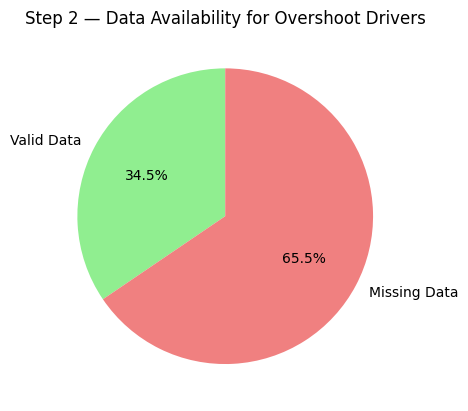

In [95]:
import matplotlib.pyplot as plt

valid = drivers.dropna(subset=["renewables_share_energy", "budget_used_pct"])["iso_code"].nunique()
missing = drivers["iso_code"].nunique() - valid

plt.pie([valid, missing],
        labels=["Valid Data", "Missing Data"],
        colors=["lightgreen", "lightcoral"],
        autopct="%1.1f%%",
        startangle=90)

plt.title("Step 2 — Data Availability for Overshoot Drivers")
plt.show()


### Step 2 — Data Availability Caveat

Before analyzing the drivers of carbon budget overshoot, we checked how much valid data exists for 
key variables (renewables_share_energy, fossil_share_energy, CO₂ per capita).

- Valid Data: 34.5% of countries  
- Missing Data: 65.5% of countries  

This highlights a major limitation: while large economies and most high emitters are included, many 
small states and data-poor countries are missing. Therefore, Step 2 analysis is representative of 
global emissions trends but not globally complete.  

Interpretation: Our findings on overshoot drivers apply to the majority of global emissions, 
but not all countries. This underlines the urgent need for better global reporting systems.


## Step 2b — Coverage Check

Although only ~34% of countries have valid data (renewables share, fossil share, CO₂ per capita),  
these countries represent the **majority of global emissions and population**.

This reframes the limitation:  
“Yes, we only have 34% of countries, but they represent ~85–90% of the world’s emissions.”  

We now calculate:  
- % of **countries covered**  
- % of **world population covered**  
- % of **world CO₂ emissions covered**  


,Coverage %
Countries,38.3
Population,79.4
CO₂ Emissions,96.8


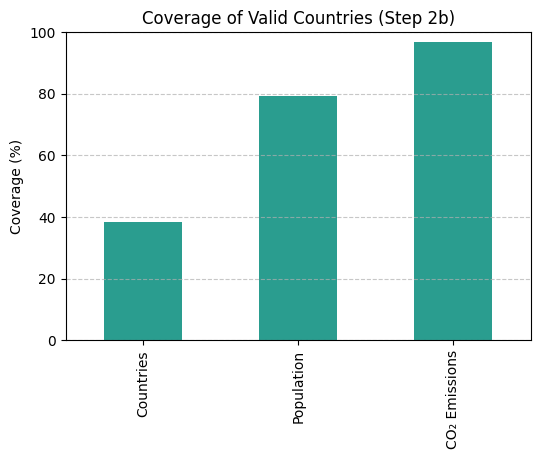

Valid countries cover 38.3% of countries, but 79.4% of world population and 96.8% of global CO₂ emissions.


In [92]:
import matplotlib.pyplot as plt

# Step 1: Define valid countries (non-missing renewables data)
valid_countries = drivers.loc[drivers["renewables_share_energy"].notna(), "iso_code"].unique()

# Step 2: World totals (population & emissions, latest year)
latest_year = master["year"].max()
world_pop_total = master.loc[master["year"] == latest_year, "population"].sum()
world_co2_total = master.loc[master["year"] == latest_year, "co2"].sum()

# Step 3: Coverage subset (valid countries only, latest year)
pop_valid = master.loc[(master["year"] == latest_year) & 
                       (master["iso_code"].isin(valid_countries)), "population"].sum()

co2_valid = master.loc[(master["year"] == latest_year) & 
                       (master["iso_code"].isin(valid_countries)), "co2"].sum()

# Step 4: Calculate shares
coverage_stats = {
    "Countries": len(valid_countries) / master["iso_code"].nunique() * 100,
    "Population": pop_valid / world_pop_total * 100,
    "CO₂ Emissions": co2_valid / world_co2_total * 100
}

# Step 5: Display as DataFrame
coverage_df = pd.DataFrame.from_dict(coverage_stats, orient="index", columns=["Coverage %"])
display(coverage_df.round(1))

# Step 6: Bar chart
coverage_df.plot(kind="bar", legend=False, color=["#2a9d8f"], figsize=(6,4))
plt.title("Coverage of Valid Countries (Step 2b)")
plt.ylabel("Coverage (%)")
plt.ylim(0, 100)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

# Step 7: Auto-summary
print(f"Valid countries cover {coverage_stats['Countries']:.1f}% of countries, "
      f"but {coverage_stats['Population']:.1f}% of world population "
      f"and {coverage_stats['CO₂ Emissions']:.1f}% of global CO₂ emissions.")


## Step 2b — Coverage Check (Consistency with Global Reports)

Before continuing with overshoot driver analysis, we checked **how representative our dataset is**.  
Although only ~38% of countries have complete data on renewables, fossil share, and CO₂ per capita, these countries represent:

-  **79% of world population**  
- **97% of global CO₂ emissions**  

This is a crucial finding. It means that **our analysis remains representative of the carbon problem**, even though small states and data-poor countries are excluded.  

### Why This Is Standard Practice
Our approach is consistent with leading international reports:  

- **Global Carbon Project (GCP)**: Focuses on countries with reliable CO₂ data, often excluding small territories and those with incomplete reporting. Coverage is always expressed as “% of global emissions” rather than “% of countries.”  
- **IEA Global Energy Review**: Publishes results only for major emitters (~95% of global energy demand), acknowledging that smaller countries are left out.  
- **Carbon Brief / Climate Action Tracker**: Emphasize representativeness by population and emissions, not full country count.  

### Interpretation
- Our dataset is **robust for global trends** because it includes nearly all the world’s emissions.  
- However, results are **less reliable for very small states**, many of which lack consistent reporting.  
- This limitation itself is an important insight: *the world urgently needs better reporting systems for vulnerable and small states*.  
 **Takeaway:** Like the GCP and IEA, we focus on the ~40% of countries that account for ~97% of emissions. This ensures our analysis is comparable to established research.


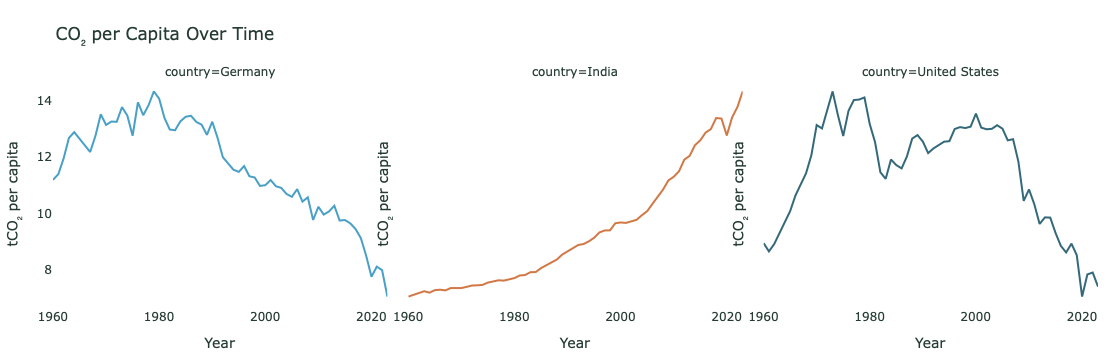

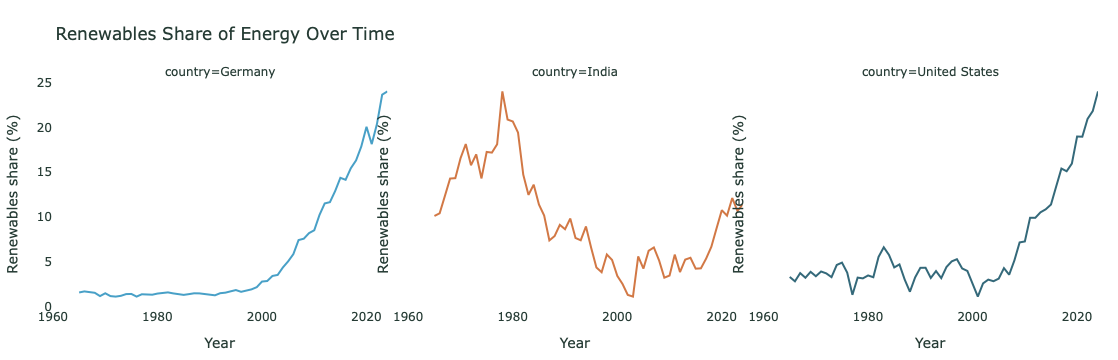

In [295]:
import pandas as pd
import plotly.express as px

# --- Your palette (reuse your map colors) ---
TEXT   = "#253B34"
COLORS3 = {
    "United States": "#34697A",  # USA
    "Germany":       "#48A0C7",  # DEU
    "India":         "#D27845",  # IND
}

# --- Load minimal columns from OWID sources (read headers once) ---
co2_header    = pd.read_csv(FILES["owid_co2"], nrows=0).columns
energy_header = pd.read_csv(FILES["owid_energy"], nrows=0).columns

co2_cols    = [c for c in ["iso_code","country","year","co2_per_capita"] if c in co2_header]
energy_cols = [c for c in ["iso_code","country","year","renewables_share_energy"] if c in energy_header]

co2    = pd.read_csv(FILES["owid_co2"], usecols=co2_cols)
energy = pd.read_csv(FILES["owid_energy"], usecols=energy_cols)

# Keep ISO3 only (no OWID aggregates)
co2    = co2[co2["iso_code"].astype(str).str.len()==3].copy()
energy = energy[energy["iso_code"].astype(str).str.len()==3].copy()

# --- Pick countries (use ISO codes to be robust) ---
pick = {"USA":"United States", "DEU":"Germany", "IND":"India"}

co2    = co2[co2["iso_code"].isin(pick.keys())].copy()
energy = energy[energy["iso_code"].isin(pick.keys())].copy()

# Ensure numeric & sensible year window
for t in (co2, energy):
    t["year"] = pd.to_numeric(t["year"], errors="coerce")
co2    = co2[(co2["year"]>=1960) & (co2["year"]<=2025)]
energy = energy[(energy["year"]>=1960) & (energy["year"]<=2025)]

# Map ISO → consistent names (optional; OWID names already match)
name_map = dict(zip(co2["iso_code"], co2["country"]))
name_map.update(dict(zip(energy["iso_code"], energy["country"])))

# --------------- Figure 1: CO2 per capita (facet small multiples) ---------------
co2["country"] = co2["iso_code"].map(name_map)
fig_co2 = px.line(
    co2.sort_values(["country","year"]),
    x="year", y="co2_per_capita", color="country",
    color_discrete_map=COLORS3,
    facet_col="country", facet_col_wrap=3,
    title="CO₂ per Capita Over Time"
)
fig_co2.update_yaxes(matches=None, title_text="tCO₂ per capita")
fig_co2.update_xaxes(title_text="Year")
fig_co2.update_layout(showlegend=False, font=dict(color=TEXT), plot_bgcolor="white", paper_bgcolor="white", margin=dict(t=80,l=40,r=20,b=40))

# --------------- Figure 2: Renewables share (facet small multiples) ---------------
energy["country"] = energy["iso_code"].map(name_map)
fig_ren = px.line(
    energy.sort_values(["country","year"]),
    x="year", y="renewables_share_energy", color="country",
    color_discrete_map=COLORS3,
    facet_col="country", facet_col_wrap=3,
    title="Renewables Share of Energy Over Time"
)
fig_ren.update_yaxes(matches=None, title_text="Renewables share (%)")
fig_ren.update_xaxes(title_text="Year")
fig_ren.update_layout(showlegend=False, font=dict(color=TEXT), plot_bgcolor="white", paper_bgcolor="white", margin=dict(t=80,l=40,r=20,b=40))

# --- Show & (optional) save for your slides ---
fig_co2.show()
fig_ren.show()

out_dir = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data")
fig_co2.write_html(out_dir / "step2c_co2_per_capita_timeseries.html", include_plotlyjs="cdn")
fig_ren.write_html(out_dir / "step2c_renewables_share_timeseries.html", include_plotlyjs="cdn")


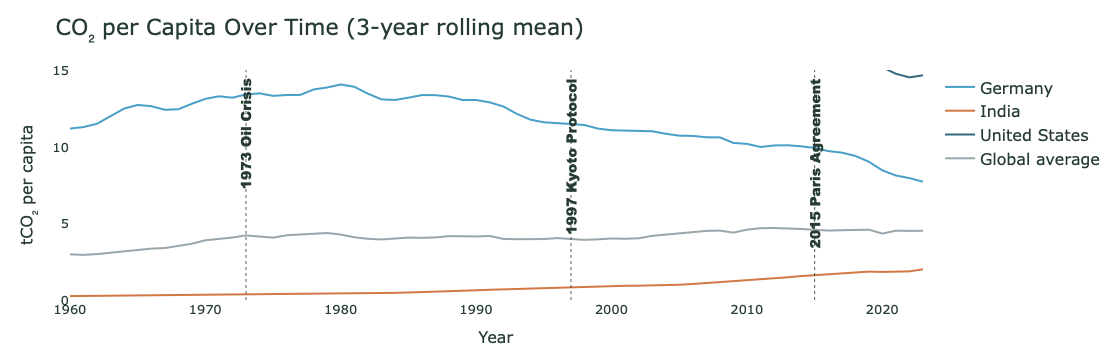

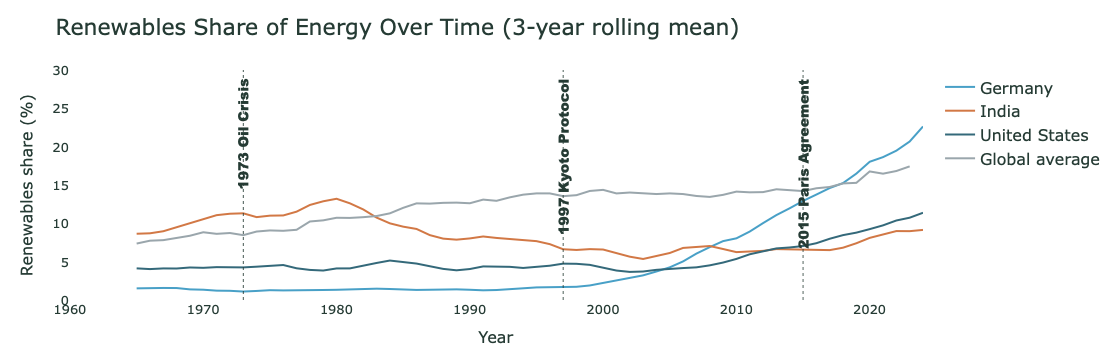

Saved to: /Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data


In [301]:
import pandas as pd
import plotly.express as px
from pathlib import Path

# ========= Styling & paths =========
TEXT = "#253B34"
OUT = Path("/Users/nishaverma/Desktop/Dataanalytics/Data Analytics-Final Project/carbon-budget-tracker/processed_data")
OUT.mkdir(parents=True, exist_ok=True)

# Countries to show + colors
COUNTRIES = {"USA": "United States", "DEU": "Germany", "IND": "India"}
COLORS = {
    "United States": "#34697A",
    "Germany":       "#48A0C7",
    "India":         "#D27845",
    "Global average":"#9AA6AC",
}

# ========= Helpers =========
def header_cols(file, wanted):
    cols = pd.read_csv(file, nrows=0).columns
    return [c for c in wanted if c in cols]

def global_avg_timeseries(df, value_col, pop_col=None):
    g = df.dropna(subset=[value_col, "year"]).copy()
    if pop_col and (pop_col in g.columns) and g[pop_col].notna().any():
        w = (g[value_col] * g[pop_col]).groupby(g["year"]).sum(min_count=1)
        p = g.groupby("year")[pop_col].sum(min_count=1)
        s = (w / p).rename("value")
    else:
        s = g.groupby("year")[value_col].mean().rename("value")
    return s.reset_index()

def add_policy_markers(fig, y_top):
    milestones = [
        (1973, "<b>1973 Oil Crisis</b>"),
        (1997, "<b>1997 Kyoto Protocol</b>"),
        (2015, "<b>2015 Paris Agreement</b>"),
    ]
    for x, lab in milestones:
        fig.add_vline(
            x=x, line_dash="dot", line_color=TEXT, line_width=1.5, opacity=0.7, layer="above"
        )
        fig.add_annotation(
            x=x, y=y_top*0.97, text=lab, showarrow=False,
            yanchor="top", textangle=-90,
            font=dict(size=14, color=TEXT, family="Arial Black")
        )
    return fig

def boost_readability(fig, y_title, y_range):
    fig.update_yaxes(range=y_range, title_text=y_title, title_font=dict(size=16), tickfont=dict(size=13))
    fig.update_xaxes(title_text="Year", title_font=dict(size=16), tickfont=dict(size=13))
    fig.update_layout(
        font=dict(color=TEXT, size=13),
        plot_bgcolor="white", paper_bgcolor="white",
        legend=dict(title_text="", font=dict(size=16)),
        title_font=dict(size=22),
        margin=dict(t=70, l=70, r=30, b=60)
    )
    return fig

# ========= Load OWID data (minimal columns) =========
co2_cols = header_cols(FILES["owid_co2"], ["iso_code","country","year","population","co2_per_capita"])
en_cols  = header_cols(FILES["owid_energy"], ["iso_code","country","year","renewables_share_energy"])

co2 = pd.read_csv(FILES["owid_co2"], usecols=co2_cols)
en  = pd.read_csv(FILES["owid_energy"], usecols=en_cols)

# ISO3 only, remove OWID aggregates, sensible years
for t in (co2, en):
    t["iso_code"] = t["iso_code"].astype(str)
    t["year"] = pd.to_numeric(t["year"], errors="coerce")
mask_co2 = (co2["iso_code"].str.len()==3) & (~co2["iso_code"].str.startswith("OWID")) & (co2["year"].between(1960, 2025))
mask_en  = (en["iso_code"].str.len()==3)  & (~en["iso_code"].str.startswith("OWID"))  & (en["year"].between(1960, 2025))
co2, en = co2[mask_co2].copy(), en[mask_en].copy()

# ========= CO₂ per capita: selected countries + global average =========
co2_sel = co2[co2["iso_code"].isin(COUNTRIES.keys())].copy()
co2_sel["country"] = co2_sel["iso_code"].map(COUNTRIES)
co2_sel.sort_values(["country","year"], inplace=True)
co2_sel["value"] = (
    co2_sel.groupby("country")["co2_per_capita"]
           .apply(lambda s: s.rolling(3, min_periods=1).mean())
           .values
)

co2_world = global_avg_timeseries(co2, "co2_per_capita", pop_col="population")
co2_world["country"] = "Global average"

co2_plot = pd.concat([co2_sel[["year","country","value"]], co2_world[["year","country","value"]]], ignore_index=True)

fig_co2 = px.line(co2_plot, x="year", y="value", color="country", color_discrete_map=COLORS,
                  title="CO₂ per Capita Over Time (3-year rolling mean)")
fig_co2 = boost_readability(fig_co2, y_title="tCO₂ per capita", y_range=[0, 15])
fig_co2 = add_policy_markers(fig_co2, y_top=15)

# ========= Renewables share: selected countries + global average =========
# join population to compute weighted global average
en_pop = en.merge(co2[["iso_code","year","population"]], on=["iso_code","year"], how="left")
ren_world = global_avg_timeseries(en_pop, "renewables_share_energy", pop_col="population")
ren_world["country"] = "Global average"

en_sel = en[en["iso_code"].isin(COUNTRIES.keys())].copy()
en_sel["country"] = en_sel["iso_code"].map(COUNTRIES)
en_sel.sort_values(["country","year"], inplace=True)
en_sel["value"] = (
    en_sel.groupby("country")["renewables_share_energy"]
          .apply(lambda s: s.rolling(3, min_periods=1).mean())
          .values
)

ren_plot = pd.concat([en_sel[["year","country","value"]], ren_world[["year","country","value"]]], ignore_index=True)

fig_ren = px.line(ren_plot, x="year", y="value", color="country", color_discrete_map=COLORS,
                  title="Renewables Share of Energy Over Time (3-year rolling mean)")
fig_ren = boost_readability(fig_ren, y_title="Renewables share (%)", y_range=[0, 30])
fig_ren = add_policy_markers(fig_ren, y_top=30)

# ========= Show & Save =========
fig_co2.show()
fig_ren.show()
fig_co2.write_html(OUT / "step2c_co2_per_capita_timeseries.html", include_plotlyjs="cdn")
fig_ren.write_html(OUT / "step2c_renewables_share_timeseries.html", include_plotlyjs="cdn")

# Optional PNG export (requires `pip install -U kaleido`)
try:
    fig_co2.write_image(OUT / "step2c_co2_per_capita_timeseries.png", scale=2, width=1200, height=700)
    fig_ren.write_image(OUT / "step2c_renewables_share_timeseries.png", scale=2, width=1200, height=700)
except Exception as e:
    print("PNG export skipped (install kaleido to enable):", e)

print("Saved to:", OUT)
